<a href="https://colab.research.google.com/github/Alejandro-666/Machine_Learning_Retail/blob/main/Proyecto_M%C3%B3dulo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Proyecto Módulo 2: Análisis de datos de una tienda Retail** 
---

**Estudiante: Sergio Alejandro Alvarado Parada.**


En el siguiente proyecto final se analizará la información de ventas recopilada de una tienda retail, con diferentes canales de venta en Estados Unidos entre los enero de 2011 y febrero de 2014. Este proyecto es la continuación del proyecto del módulo 1. 

In [ ]:
# Importar librerías de interés

import numpy as np
import pandas as pd
import matplotlib  
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("darkgrid")

##**1. Entendimiento del negocio**
---
El retail es un modelo de negocio donde se venden al por menor o al detalle una gran cantidad de productos, es un mercado donde hay una gran cantidad de competidores donde algunos de ellos tienen bastante dominantes debido a su gran disposición de capital y su capacidad de mantener precios bajos incurriendo incluso en pérdidas para atraer a más clientes y sacar competidores de este mercado. El retail se caracterisa principalmente por la venta de diferentes producto de varias categorías y subcategorías, lo que lo convierte en un negocio donde generalmente es necesario administrar cada categoría independientemente, sin embargo todas, al final de la operación, contribuyen al crecimiento del establecimiento.


En este proyecto se realizará el análisis de la información de una tienda retail, simulando un escenario donde el gerente o dueño de una tienda quiere identificar información oculta en los registros de transacciones para implementar mejores estrategias de crecimiento del negocio.

####**1.2. Objetivos del proyecto**
---
El principal objetivo del proyecto es aplicar ténicas de aprendizaje de máquina (machine learning) a los datos del neocio para encontrar información oculta importante que permita predecir ventas de algunos productos y clasificación de clientes para campañas de marketing principalmente.

##**2. Recolección y entendimiento de los datos**
---
La información utilizada para este proyecto se obtuvo de la página www.kaggle.com, lo que significa que son datos abierto al público en general. El enlace al conjunto de datos se presenta al final del notebook en la sección 6 (Referencias).

Dentro de la exploración y preparación de datos relizada en el proyecto del módulo 1 a la información base, se realizaron las siguientes actividades.

*   **Identificación de datasets y categorías:** En este ítem se identificó toda la información disponible. La información base se compone de tres datasets iniciales; el dataset de clientes, el dataset de transacciones y el diccionario de definición de categorías y subcategorías de los productos.

*   **Unificación de los datasets:**  La unificación de estos datasets se realizó a través de las columnas en común para tener toda la información disponile en un único dataset.

*   **Eliminación de características que no tienen definición:** Esto significa que dentro de la información original se encontraban características (columnas) con siglas que no contaban con una descripción de su significado. Por ejemplo la columna llamada **DBO** no tiene definición y no se conoce qué representa, por lo que se eliminó de la información con la cual trabajar.

*   **Eliminación de los ejemplos con registros vacíos:** En la información base se encontraban inicialmente 23.053 ejemplos de transacciones, sin embargo algunos de estos registros no contaban con toda la información. Considerando que los ejemplos con características incompletas son 17, se elminaron ya que estos representan el 0,074% de la totalidad de los datos.

*   **Exploración para identificación de datos anómalos:** Se realizó una exploración visual para identificar posibles datos anómalos dentro de la información base. Sin embargo no se encontró nada anormal dentro de la naturaleza del negocio.

Con la preparación de la información reaizada en el proyecto del módulo 1 se creó un archivo csv con la información recopilada, unificada y preparada, el cual es el archivo base para la elaboración de este proyecto. A continuación se cargan los datos y se realizan las modificaciones necesarias que permitan trabajar correctamente la información.

In [ ]:
# Cargar la información en la variable Transacciones

Transacciones = pd.read_csv('Transacciones_m1.csv')

Transacciones.head()

,Unnamed: 0,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,Age,Gender,city_code,prod_cat,prod_subcat
0,0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop,79,M,5.0,Clothing,Women
1,1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop,15,F,8.0,Electronics,Computers
2,2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,71,M,8.0,Books,DIY
3,3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop,56,M,3.0,Home and kitchen,Bath
4,4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,71,M,8.0,Books,DIY


In [ ]:
# Eliminación de la columna 'Unnamed: 0'

del Transacciones['Unnamed: 0']

In [ ]:
# Creación de la columna 'Date' y en ella transformar los strings de fechas en objetos datetime

Transacciones['Date'] = pd.to_datetime(Transacciones['tran_date'], dayfirst=True)

In [ ]:
# Ordenar las transacciones por fechas

Transacciones = Transacciones.sort_values('Date')

##**3. Series de tiempo enfocado a ventas de productos**: 
---

Como tarea inicial se realizará en análisis de la serie de tiempo de un producto en particular, tratando de predecir las ventas de este producto en particular en un periodos posterior al de los registros obtenidos en los diferentes canales de distribución. Por decisión aleatoria se seleccionó la categoría Libros (Books) como categoría para analizar.

In [ ]:
# Identificación de los canales de distribución actuales

stores = Transacciones['Store_type'].unique()

for store in stores:
  print(f'Canal de distribución 1: {store}')

Canal de distribución 1: TeleShop
Canal de distribución 1: Flagship store
Canal de distribución 1: MBR
Canal de distribución 1: e-Shop


In [ ]:
# Creación de un DataFrame que contenta únicamente la información de libros (Books)

Books_sales = Transacciones.loc[Transacciones['prod_cat'] == 'Books']

In [ ]:
# Se eliminaran los ejempls con registros negativos (devoluciones)

Books_sales = Books_sales.loc[Books_sales['total_amt'] > 0]

In [ ]:
Books_sales.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,Age,Gender,city_code,prod_cat,prod_subcat,Date
23035,77960931771,271961,25-01-2011,11,5,1,447,46.935,493.935,TeleShop,35,M,1.0,Books,Children,2011-01-25
23019,46821751538,269160,25-01-2011,10,5,5,941,494.025,5199.025,TeleShop,48,F,1.0,Books,Non-Fiction,2011-01-25
23020,9423947512,267383,25-01-2011,3,5,1,333,34.965,367.965,e-Shop,57,M,10.0,Books,Comics,2011-01-25
23034,72870271171,270911,25-01-2011,11,5,3,1142,359.730,3785.730,TeleShop,49,M,2.0,Books,Children,2011-01-25
23026,49882891062,271982,25-01-2011,10,5,4,1330,558.600,5878.600,e-Shop,24,M,8.0,Books,Non-Fiction,2011-01-25


In [ ]:
# Definición de una función que permita graficar las series de tiempo.

def print_series(series, etiqueta):
  plt.figure(figsize=(10,3), dpi = 110)
  plt.plot(series, color="g", label=etiqueta, linewidth=1)
  plt.title('Serie de Tiempo')
  plt.grid()
  plt.legend()
  plt.xlabel("Fecha")
  plt.ylabel("Total Ventas ($)")
  print()

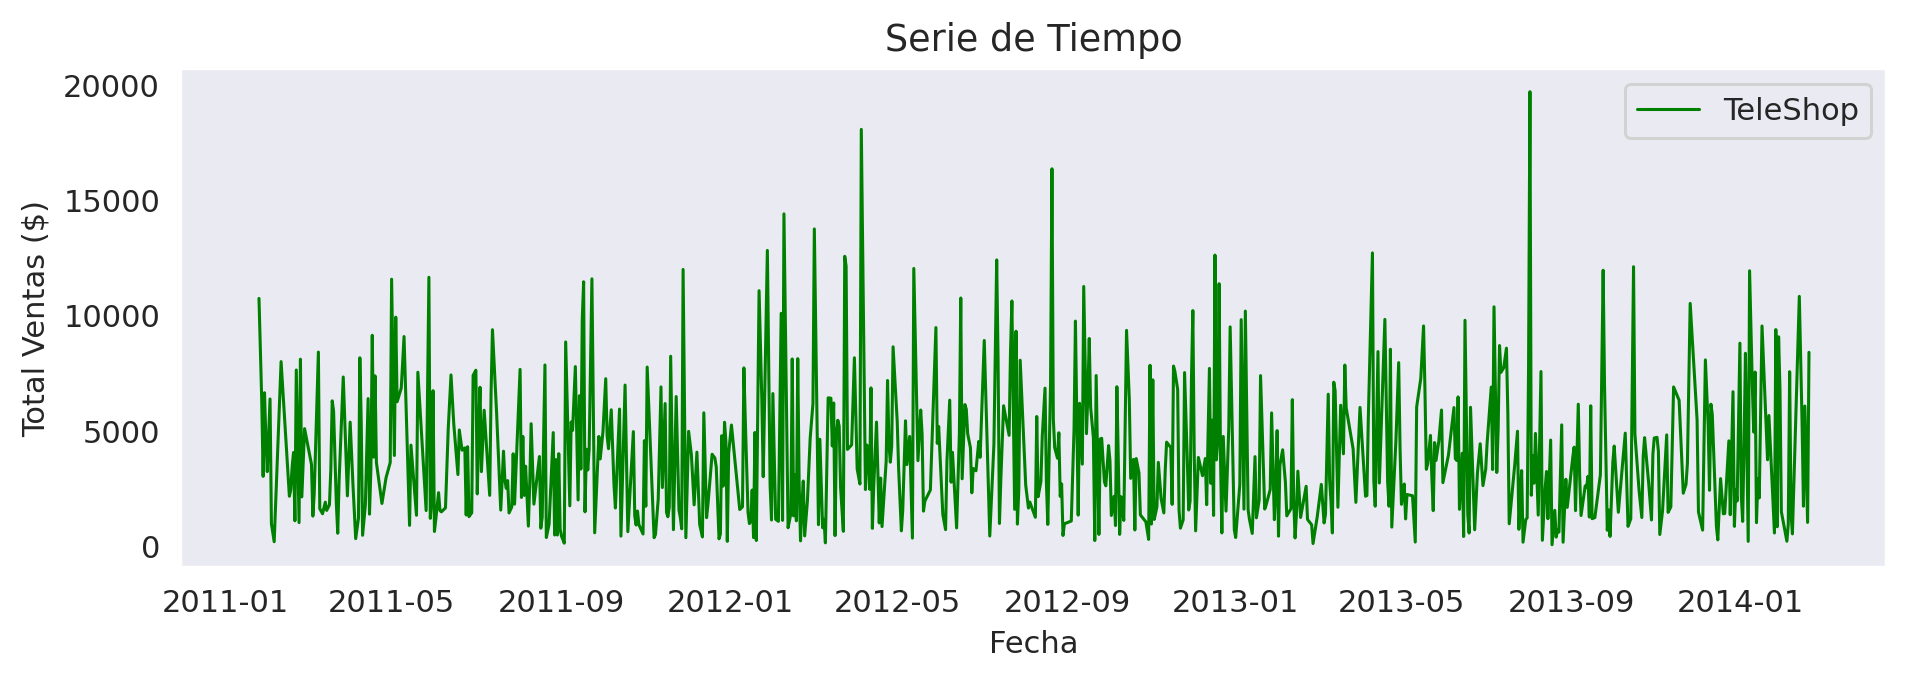

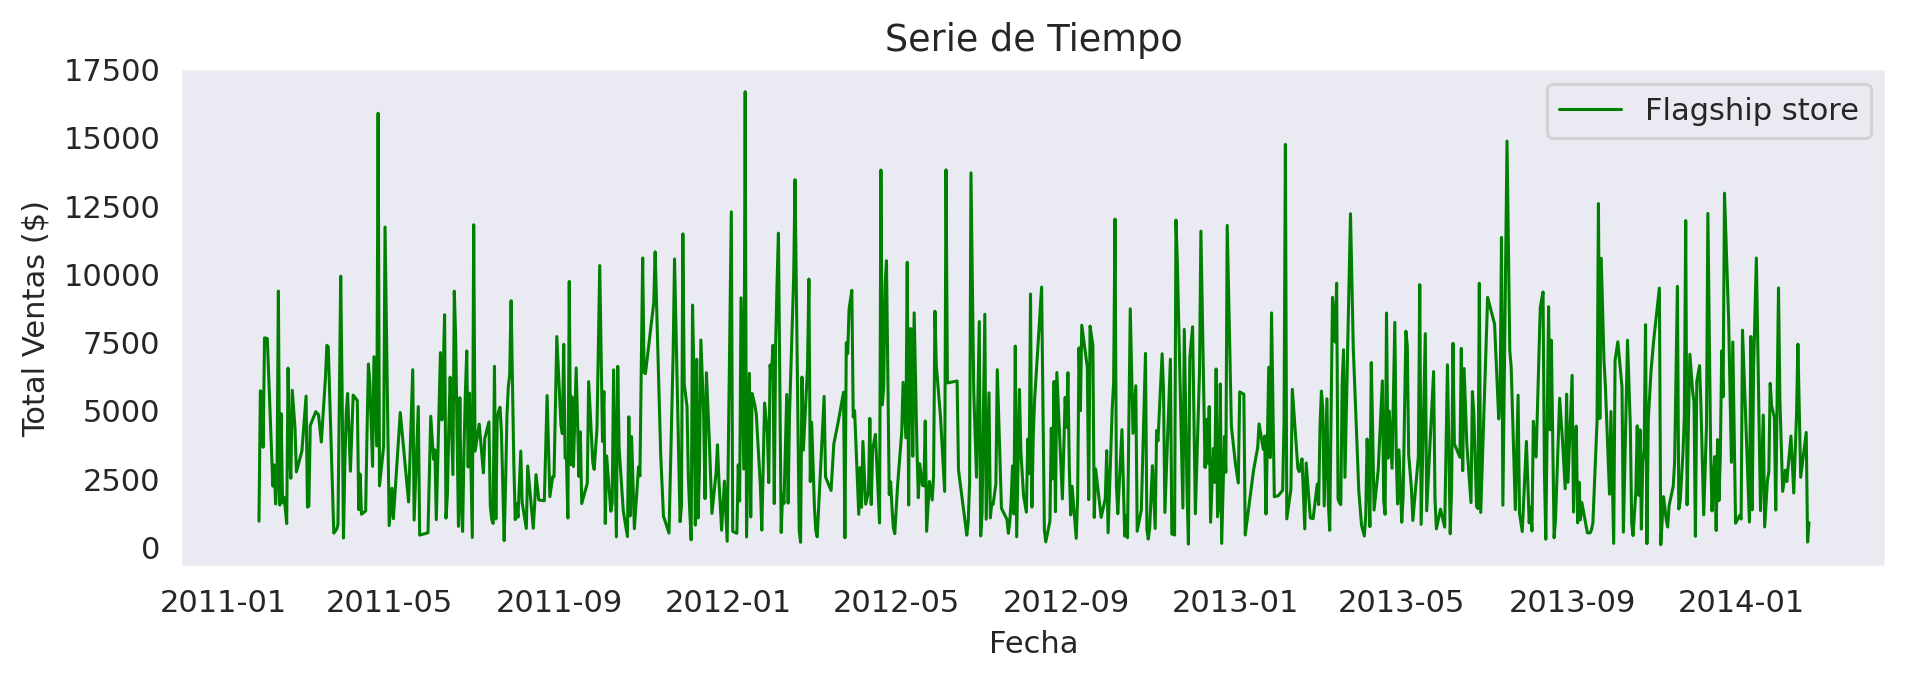

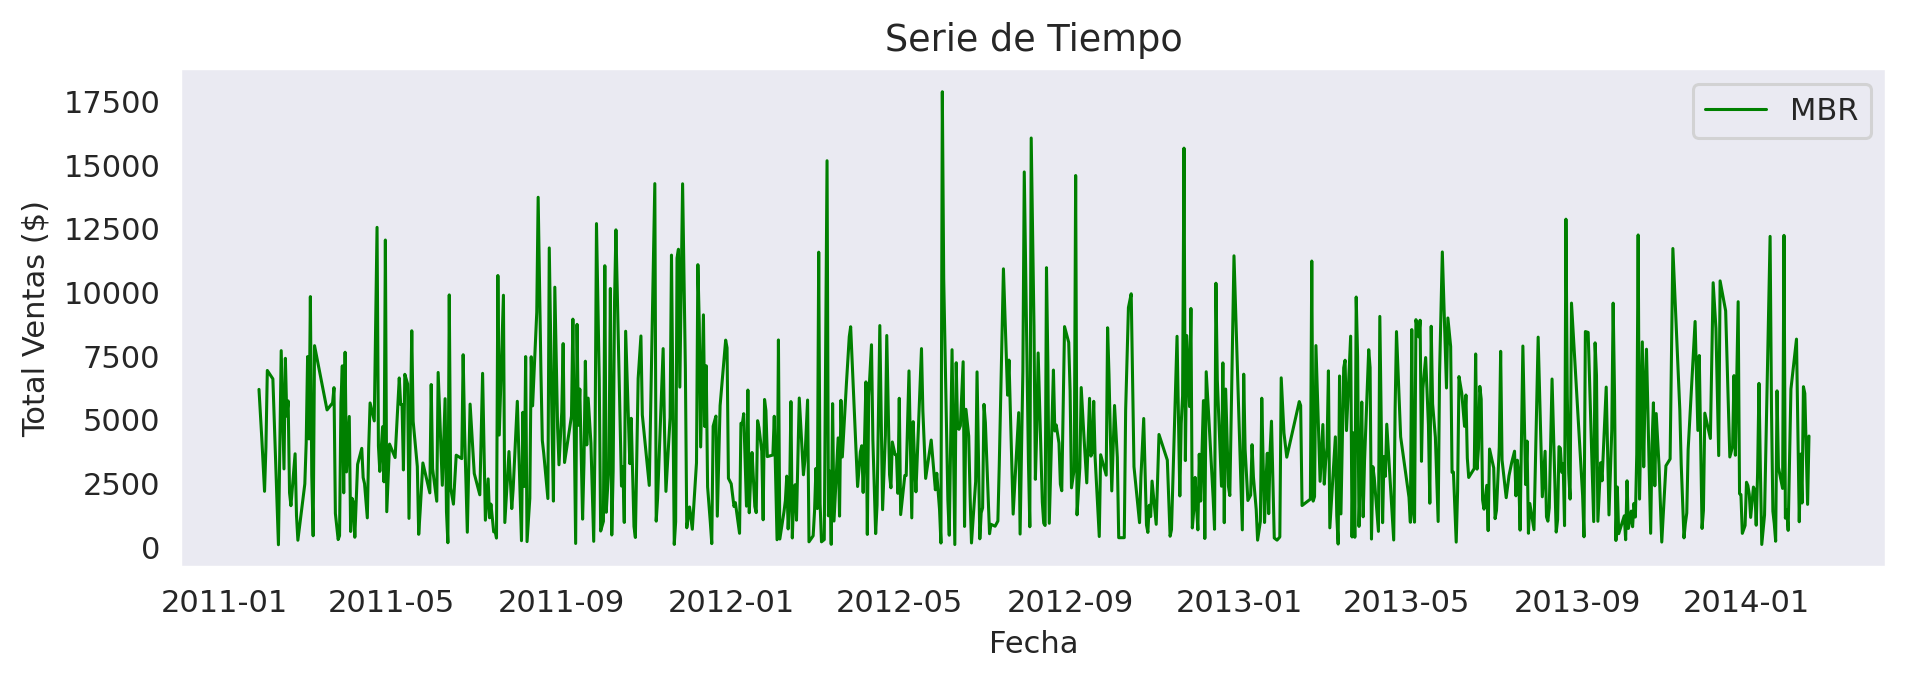

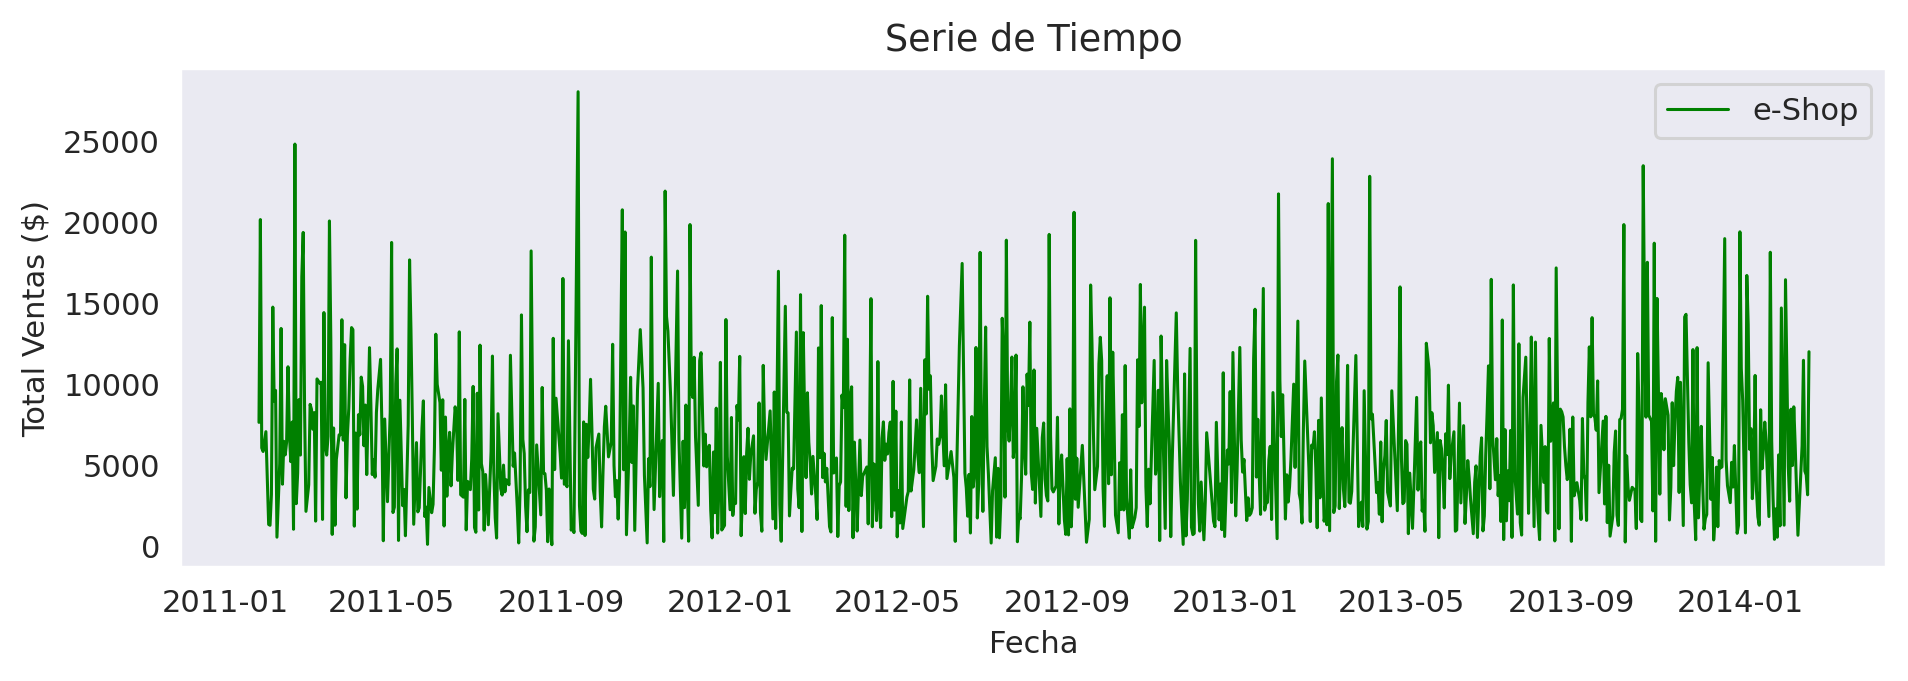

In [ ]:
# Celda para visualizar las series de tiempo de cada tipo de tienda (Books)

for store in stores:
  Books = Books_sales.loc[Books_sales['Store_type'] == store]
  Books = Books.groupby('Date').agg({'total_amt': np.sum})

  print_series(Books, store)

In [ ]:
# Código que permite conocer la cantidad de ventas en cada canal de distribución 

stores_count = []
for store in stores:
  x = Books_sales.loc[Books_sales['Store_type'] == store]
  x = x.shape[0]
  stores_count.append(x)
for i in range(len(stores_count)):
  print(f"Tipo de tienda: {stores[i]},\n\t Cantidad de ventas: {stores_count[i]}")

Tipo de tienda: TeleShop,
	 Cantidad de ventas: 1074
Tipo de tienda: Flagship store,
	 Cantidad de ventas: 1098
Tipo de tienda: MBR,
	 Cantidad de ventas: 1098
Tipo de tienda: e-Shop,
	 Cantidad de ventas: 2211


####**3.1. Serie de tiempo con datos originales (sin modificar)**
---

Debido a que el proceso de creación del análisis de la serie de tiempo para cada una de los canales de distribución es similar y considerando las limitaciones de tiempo, se realizará el análisis de un solo canal de distribución, con el cual se pueden realizar diferentes modificaciones para obtener un mejor resultado al momento de evaluar el modelo para la serie de tiempo.

Para la elaboración del análisis se utilizará la información de ventas del canal **Teleshop** referente a ventas de libros (Books). Ya que cada día puede tener más de una venta, se realizó la suma de ventas por cada día registrado en los datos de transacciones, para realizar este proceso se utilizará un pd.groupby.

In [ ]:
# Serie de tiempo de libros vendidos por Teleshp

Books_Teleshop = Books_sales.loc[Books_sales['Store_type'] == 'TeleShop']
Books_Teleshop = Books_Teleshop.groupby('Date').agg({'total_amt': np.sum}) # Suma de ventas diarias de Teleshop

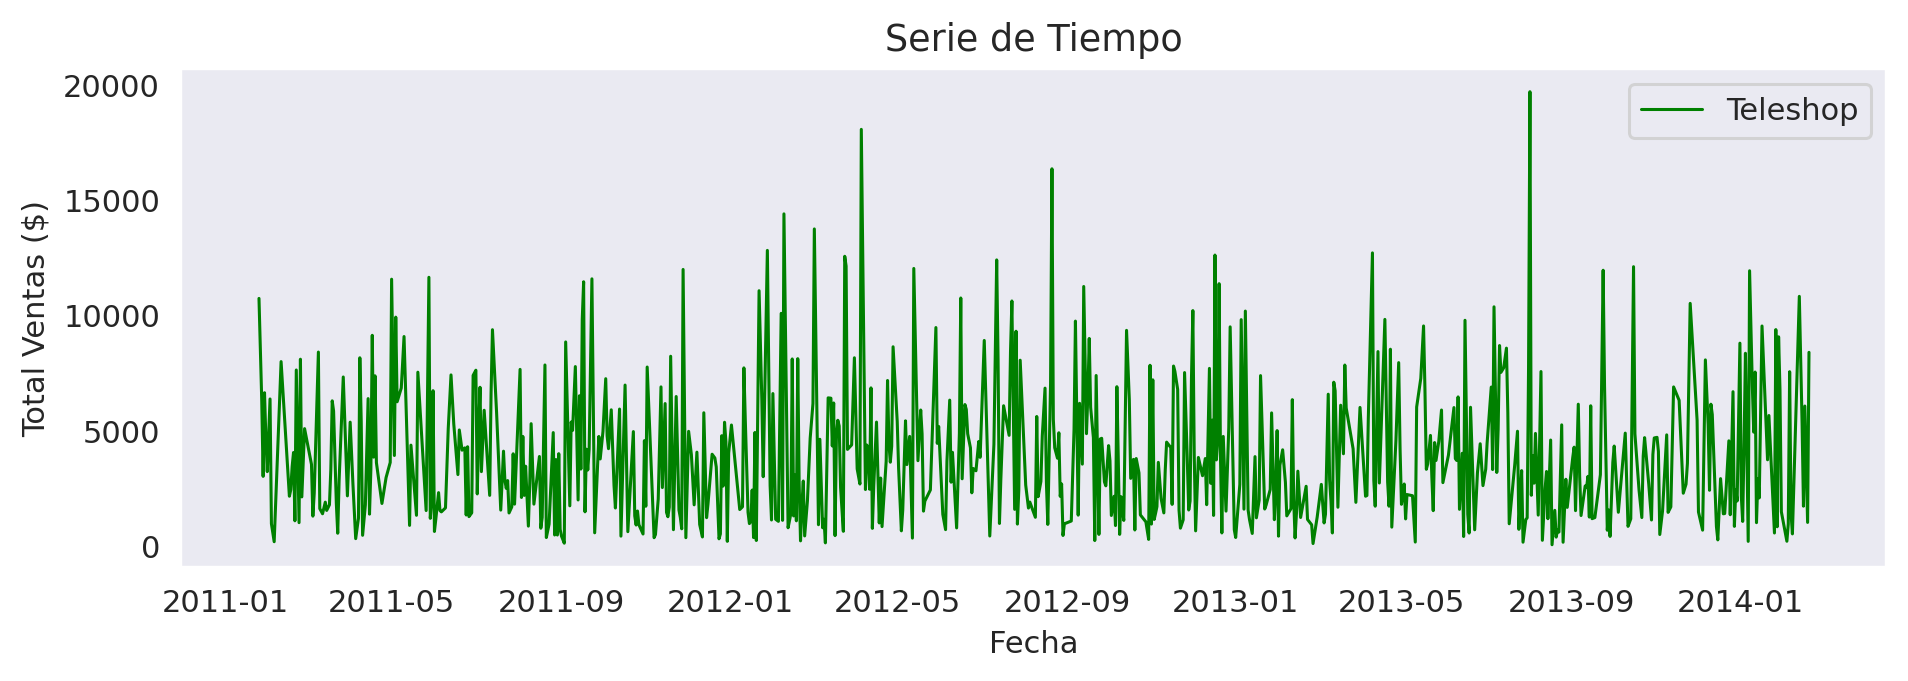

In [ ]:
# Gráfica de la serie de tiempo para las ventas diarias de libros (Books) a través del canal Teleshop

print_series(Books_Teleshop, "Teleshop")

In [ ]:
# Tamaño de la serie de tiempo de ventas diarias a través de Teleshop

Books_Teleshop.shape

(700, 1)

A continuación se define una función auxiliar que permita hacer la separación de la serie de tiempo en serie de entrenamiento (data_train) y serie de prueba (data_test):

In [ ]:
# Función para crear los arreglos data_train y data_test

def temporal_split(series, p=0.3):
  """
  Entradas:
    series : Arreglo de NumPy con shape (n,) con la serie de tiempo.
    p :porcentaje de datos destinados para la partición de prueba
  Retorna:
    series_train: Arreglo de NumPy con partición de entrenamiento de la serie de tiempo.
    series_test: Arreglo de NumPy con partición de prueba de la serie de tiempo.
  """
  
  n = series.shape[0]
  series_train = series[:round(n*(1-p))]
  series_test = series[round(n*(1-p)):]
 
  return series_train, series_test

Se define adicionalmente un funcion que permita crear la matriz de observaciones *X* y el vector de etiquetas *y* tanto para la serie de entrenamiento como serie de prueba:

In [ ]:
#Función que permite crear las ventanas para el análisis (Matriz X y vector y)

def temporal_window(series, w):
  """
  Entradas:
    series: Arreglo de NumPy con tamaño (n,), una serie de tiempo
    w: Número entero, tamaño de las ventanas de tiempo.
  Retorna:    
    X: Arreglo de NumPy con shape(n - w, w), las ventanas temporales.
    y: Arreglo de NumPy con shape(n - w,), el valor siguiente en la serie para cada ventana.
  """
  
  series = series.squeeze()
  n = series.shape[0] - w
  X = np.empty((n, w))
  y = np.empty(n)

  for i in range(n):
    y[i] = series[w + i]
    X[i,:] = np.array(series[i:i+w])

  return X, y

Finalmente y por facilidad se define una función que cree las matrices *X_train, X_test*, los vectores *y_train, y_test* y las series de tiempo *data_train, data_test*:

In [ ]:
#Función que reune las funciones temporal_split y temporal_window

def Split_Window(series, w=20, p=0.3):
  
  series_train, series_test = temporal_split(series, p)
  X_train, y_train = temporal_window(series_train, w)
  X_test, y_test = temporal_window(series_test, w)

  return X_train, X_test, y_train, y_test, series_train, series_test

Para la creación de las matrices de ejemplos *X* y los vectores de observación *y* es necesario definir el tamaño de la ventana de observaciones y el procentaje de datos utilizados para realizar las pruebas. Para este caso en particular se realizarán los análisis con una ventana de tamaño 20 (*k* = 20) y un porcentaje de datos de prueba del 30% (*p* = 30%).

In [ ]:
# Tamaño de ventana para el análisis
k = 20

In [ ]:
# Porcentaje de la serie para test
p = 0.3

In [ ]:
# Creación de las Matrices X, los vectores y y las series de tiempo (train - test)

X_train, X_test, y_train, y_test, data_train, data_test = Split_Window(Books_Teleshop, k, p)

In [ ]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,10747.230,6310.655,3038.750,6663.150,4685.200,3244.280,6392.425,985.66,207.74,8011.250,2179.060,2459.730,3460.860,4074.135,1113.840,7647.705,1034.280,8115.120,2149.225,5107.310
1,6310.655,3038.750,6663.150,4685.200,3244.280,6392.425,985.660,207.74,8011.25,2179.060,2459.730,3460.860,4074.135,1113.840,7647.705,1034.280,8115.120,2149.225,5107.310,3558.100
2,3038.750,6663.150,4685.200,3244.280,6392.425,985.660,207.740,8011.25,2179.06,2459.730,3460.860,4074.135,1113.840,7647.705,1034.280,8115.120,2149.225,5107.310,3558.100,1316.055
3,6663.150,4685.200,3244.280,6392.425,985.660,207.740,8011.250,2179.06,2459.73,3460.860,4074.135,1113.840,7647.705,1034.280,8115.120,2149.225,5107.310,3558.100,1316.055,2313.870
4,4685.200,3244.280,6392.425,985.660,207.740,8011.250,2179.060,2459.73,3460.86,4074.135,1113.840,7647.705,1034.280,8115.120,2149.225,5107.310,3558.100,1316.055,2313.870,8424.520


In [ ]:
pd.Series(y_train).head()

0    3558.100
1    1316.055
2    2313.870
3    8424.520
4    1643.135
dtype: float64

In [ ]:
# Verificación de la cantidad de registros en las matrices X, vectores y y las series de tiempo

print(f'X_train: {X_train.shape}\nX_test: \
    {X_test.shape}\ny_train: \
    {y_train.shape} \ny_test: {y_test.shape}\ndata_train: \
    {data_train.shape}\ndata_test: {data_test.shape}')

X_train: (470, 20)
X_test:     (190, 20)
y_train:     (470,) 
y_test: (190,)
data_train:     (490, 1)
data_test: (210, 1)


In [ ]:
# Definición de una función que permita visualizar la separación de la serie de tiempo

def plot_series_separada(series, p):
  n = series.shape[0]

  plt.figure(figsize=(10,3), dpi = 110)
  plt.plot(series[:round(n*(1-p))], ls="-", label="Entrenamiento", linewidth=1)
  plt.plot(series[round(n*(1-p)):], ls="-", label="Prueba", linewidth=1)
  plt.title("Serie de Tiempo Separada (Entrenamiento - Prueba")
  plt.legend()
  plt.grid()
  plt.xlabel("Fecha")
  plt.ylabel("Valor ($)")

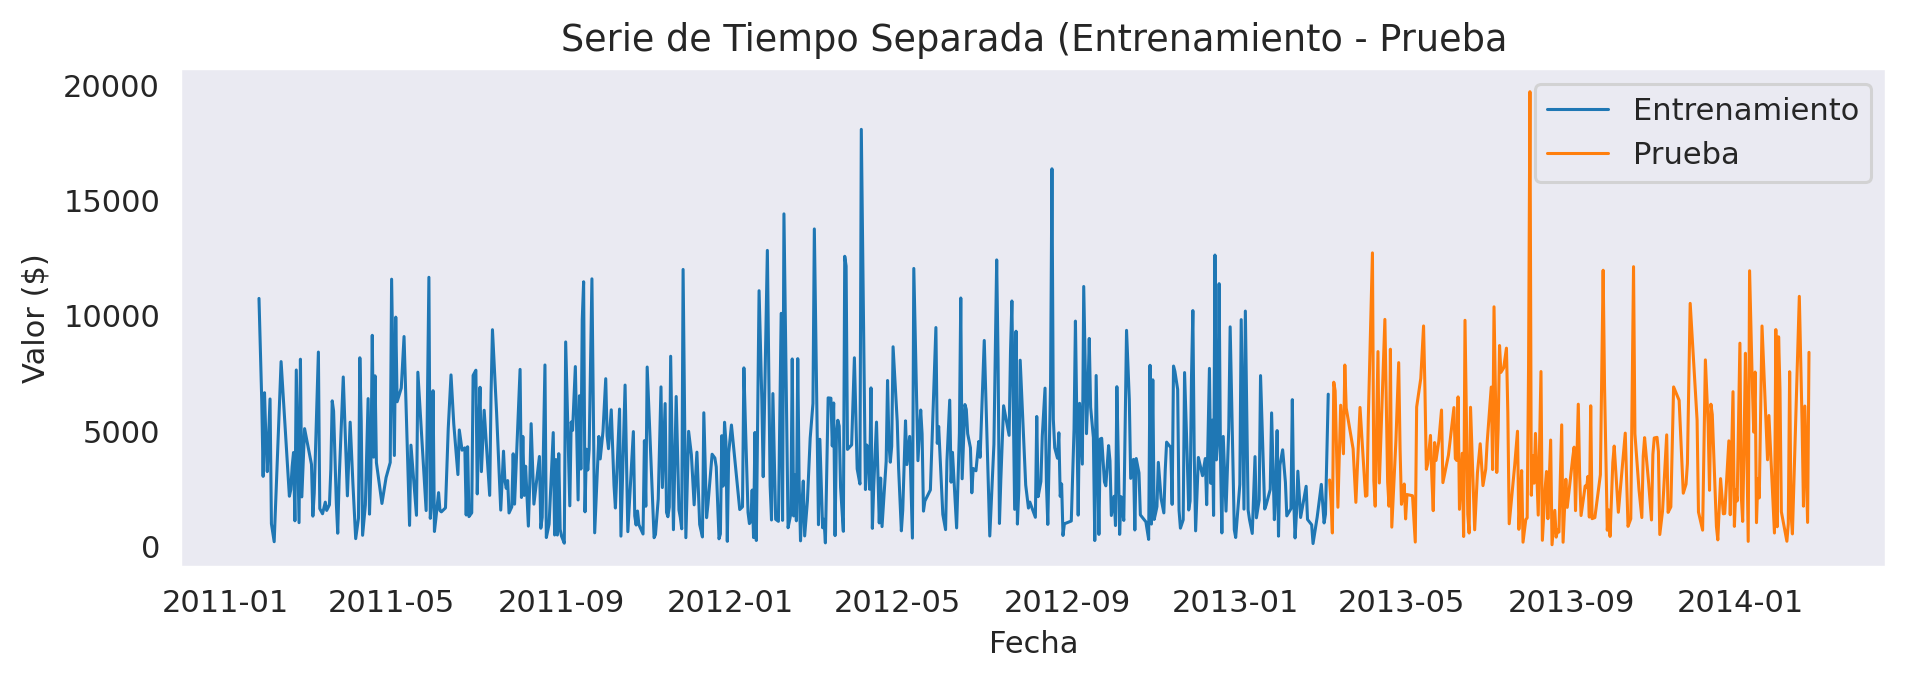

In [ ]:
plot_series_separada(Books_Teleshop, p)

In [ ]:
# Importar los módulos necesarios para el modelo

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neural_network import MLPRegressor

# Creación del objeto time series split

tsp = TimeSeriesSplit(n_splits = 3)

In [ ]:
parametros = {
    'solver' : ['adam', 'sgd', 'lbfgs'],
    'alpha' : [0.001, 0.0001],
    'max_iter' : [200, 400, 600]
}

In [ ]:
# Creación del objeto gridsearch para validación cruzada

gridsearch = GridSearchCV(MLPRegressor(random_state=10),
                          cv=tsp,
                          param_grid=parametros)

In [ ]:
# Ajuste de la matriz X de entrenamiento y el vector de de entrenamiento al objeto GridSearch

gridsearch.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470:

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=200, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=10, shuffle=True,
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='depre

In [ ]:
# Resultados del ajuste del objeto GridSearch con X_train y y_train

pd.DataFrame(gridsearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.326003,0.212734,0.001090,0.000038,0.001,200,adam,"{'alpha': 0.001, 'max_iter': 200, 'solver': 'a...",-6.056944e-01,-3.958516e-01,-2.273191e-01,-4.096217e-01,1.547777e-01,2
1,0.018573,0.005470,0.001281,0.000226,0.001,200,sgd,"{'alpha': 0.001, 'max_iter': 200, 'solver': 's...",-4.747681e+17,-1.742304e+51,-1.750097e+50,-6.391047e+50,7.833451e+50,13
2,0.366897,0.085526,0.001183,0.000009,0.001,200,lbfgs,"{'alpha': 0.001, 'max_iter': 200, 'solver': 'l...",-1.468439e+00,-1.146401e+00,-1.405223e+00,-1.340021e+00,1.393211e-01,7
3,0.627240,0.425731,0.001112,0.000081,0.001,400,adam,"{'alpha': 0.001, 'max_iter': 400, 'solver': 'a...",-6.056944e-01,-6.762184e-01,-4.901041e-01,-5.906723e-01,7.671972e-02,3
4,0.018670,0.005683,0.001130,0.000009,0.001,400,sgd,"{'alpha': 0.001, 'max_iter': 400, 'solver': 's...",-4.747681e+17,-1.742304e+51,-1.750097e+50,-6.391047e+50,7.833451e+50,13
5,0.664857,0.255108,0.001178,0.000011,0.001,400,lbfgs,"{'alpha': 0.001, 'max_iter': 400, 'solver': 'l...",-1.468443e+00,-1.149012e+00,-1.442237e+00,-1.353231e+00,1.448004e-01,9
6,0.925923,0.644076,0.001159,0.000027,0.001,600,adam,"{'alpha': 0.001, 'max_iter': 600, 'solver': 'a...",-6.056944e-01,-8.280677e-01,-7.068601e-01,-7.135407e-01,9.090632e-02,5
7,0.018488,0.005273,0.001132,0.000013,0.001,600,sgd,"{'alpha': 0.001, 'max_iter': 600, 'solver': 's...",-4.747681e+17,-1.742304e+51,-1.750097e+50,-6.391047e+50,7.833451e+50,13
8,0.862703,0.398304,0.001196,0.000011,0.001,600,lbfgs,"{'alpha': 0.001, 'max_iter': 600, 'solver': 'l...",-1.468443e+00,-1.149005e+00,-1.442509e+00,-1.353319e+00,1.448591e-01,10
9,0.322415,0.209572,0.001208,0.000099,0.0001,200,adam,"{'alpha': 0.0001, 'max_iter': 200, 'solver': '...",-6.052458e-01,-3.897649e-01,-2.277388e-01,-4.075832e-01,1.546308e-01,1


In [ ]:
# Mejor estimador

clf = gridsearch.best_estimator_
clf

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=10, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [ ]:
# Predicción de la serie de tiempo

y_pred = clf.predict(X_test)

In [ ]:
# Definición de la función que permite graficar y_pred y y_test en el mismo espacio

def plot_prediccion_real(y_pred, y_test, data_test):

  x = data_test.index[k:] #Los 20 datos iniciales antes de k está en la matriz X_test

  plt.figure(figsize=(10,3), dpi = 110)
  plt.plot(x, y_test, label="Valor verdadero")
  plt.plot(x, y_pred, label="Valor predicho")
  plt.title("Predicción vs valores verdaderos")
  plt.legend()
  plt.grid()

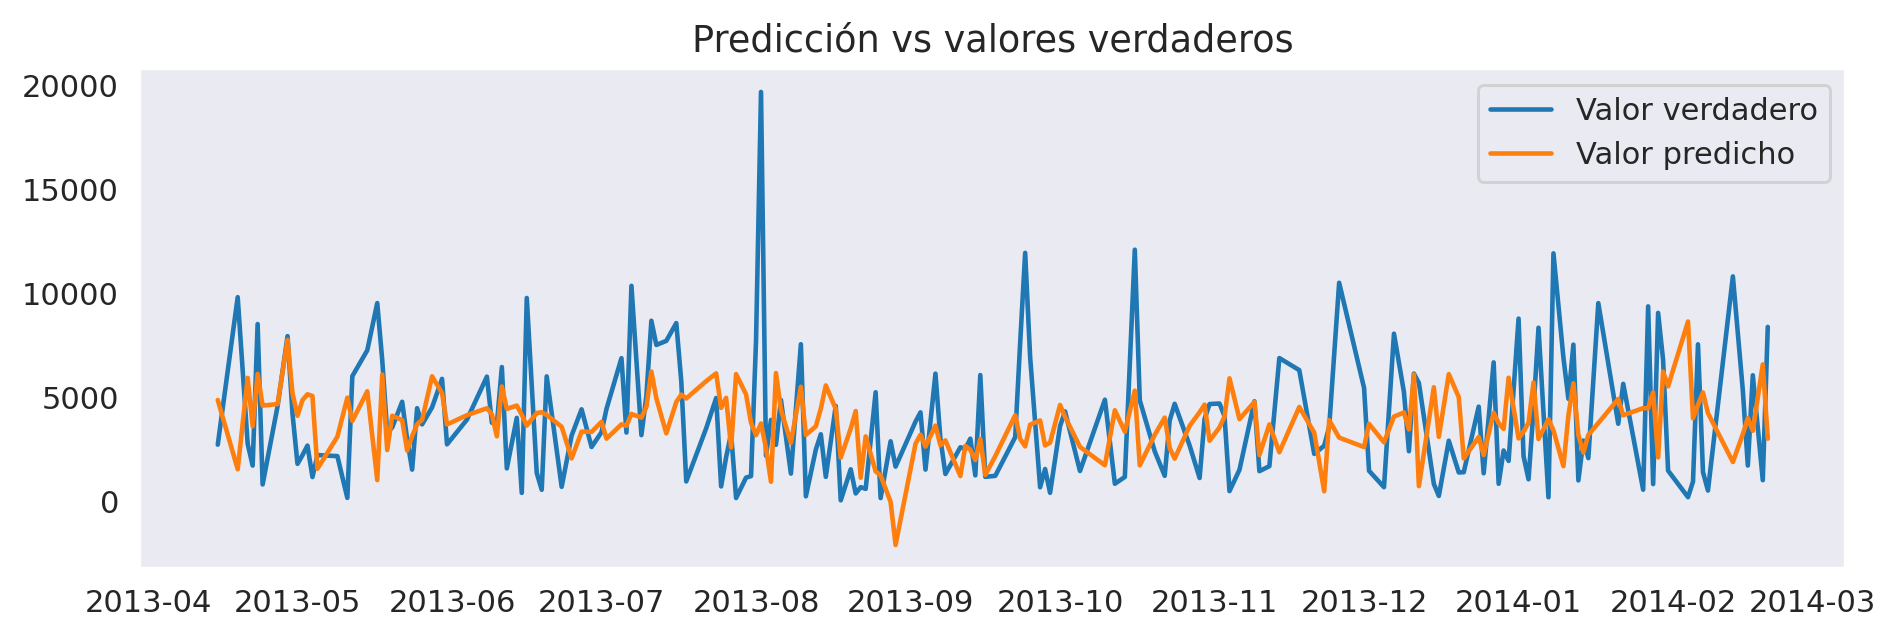

In [ ]:
plot_prediccion_real(y_pred, y_test, data_test)

In [ ]:
# Importar paquete de métricas para evaluar el modelo

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score 

In [ ]:
# Métricas de desempeño

print(f"Test Mean Squared Error: \t{mean_squared_error(y_test, y_pred):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test, y_pred):.4f}")
print(f'Coeficiente de Determinación con r2_score:, {r2_score(y_test, y_pred):.4f}')

Test Mean Squared Error: 	15382185.3850
Test Mean Absolute Error: 	2986.1148
Coeficiente de Determinación con r2_score:, -0.6393


In [ ]:
# Valores máximos y mínimos de la predicción de la serie de tiempo

print('Valor máximo de la predicción:', y_pred.max())
print('Valor mínimo de la predicción:', y_pred.min())

Valor máximo de la predicción: 8669.379777425424
Valor mínimo de la predicción: -2068.0794878334646


####**3.2. Serie de tiempo con datos ajustados (ajuste logarítmico)**
---
En busca de un mejor ajuste a la serie de tiempo y teniendo en cuenta que los valores que se registran en la serie de tiempo varian desde casi cero hasta 20.000 se plantea escalar los datos de forma logarítmica para ver cómo este ajuste afecta el desempeño del modelo con la serie de tiempo trabajada anteriormente sin ajuste alguno. A continuación se presenta el procedimiento del ajuste.

In [ ]:
# Ajuste logarítmico de la serie de tiempo

log_Teleshop = np.log(Books_Teleshop) # Escalar logaritmicamente la serie

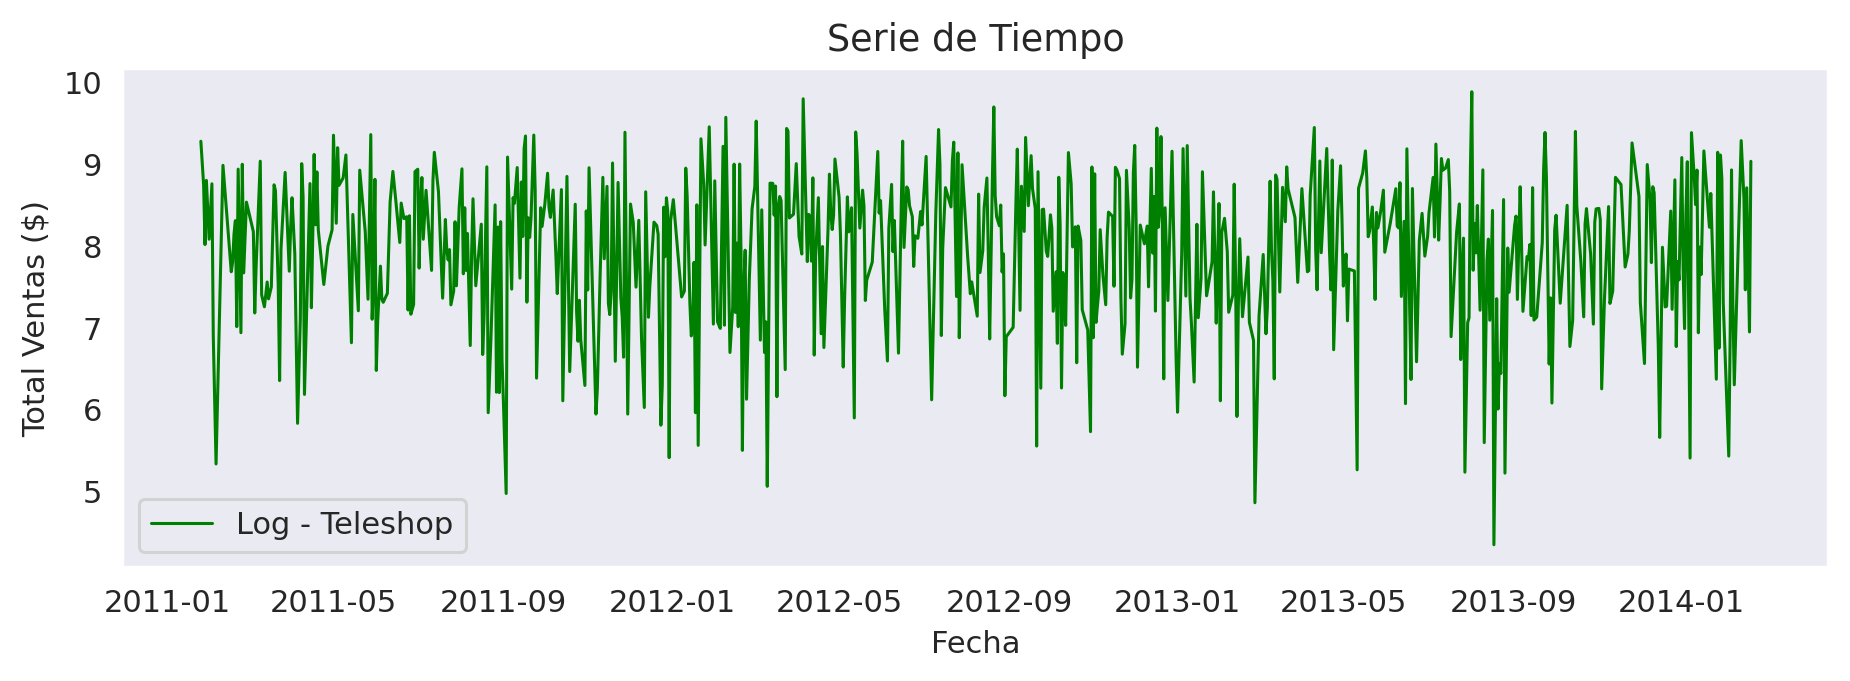

In [ ]:
# Visualización de la serie de tiempo en escala logarítmica

print_series(log_Teleshop, 'Log - Teleshop')

In [ ]:
# Creación de las matrices X, series de tiempo y vectores y (log)

X_train_log, X_test_log, y_train_log, y_test_log, dtrain_log, dtest_log = Split_Window(log_Teleshop, k, p)

In [ ]:
print('X_train_log.shape:', X_train_log.shape)
print('y_train_log.shape', y_train_log.shape)
print('X_test_log.shape', X_test_log.shape)
print('y_test_log.shape', y_test_log.shape)
print('dtrain_log.shape', dtrain_log.shape)
print('dtest_log.shape', dtest_log.shape)

X_train_log.shape: (470, 20)
y_train_log.shape (470,)
X_test_log.shape (190, 20)
y_test_log.shape (190,)
dtrain_log.shape (490, 1)
dtest_log.shape (210, 1)


In [ ]:
pd.DataFrame(X_train_log).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,9.282403,8.749995,8.019202,8.804348,8.452164,8.084649,8.762869,6.893311,5.336287,8.988602,7.686649,7.807807,8.149272,8.312414,7.015569,8.942161,6.941461,9.001484,7.672863,8.538428
1,8.749995,8.019202,8.804348,8.452164,8.084649,8.762869,6.893311,5.336287,8.988602,7.686649,7.807807,8.149272,8.312414,7.015569,8.942161,6.941461,9.001484,7.672863,8.538428,8.176982
2,8.019202,8.804348,8.452164,8.084649,8.762869,6.893311,5.336287,8.988602,7.686649,7.807807,8.149272,8.312414,7.015569,8.942161,6.941461,9.001484,7.672863,8.538428,8.176982,7.182394
3,8.804348,8.452164,8.084649,8.762869,6.893311,5.336287,8.988602,7.686649,7.807807,8.149272,8.312414,7.015569,8.942161,6.941461,9.001484,7.672863,8.538428,8.176982,7.182394,7.746677
4,8.452164,8.084649,8.762869,6.893311,5.336287,8.988602,7.686649,7.807807,8.149272,8.312414,7.015569,8.942161,6.941461,9.001484,7.672863,8.538428,8.176982,7.182394,7.746677,9.038902


In [ ]:
pd.Series(y_train_log)

0      8.176982
1      7.182394
2      7.746677
3      9.038902
4      7.404361
         ...   
465    7.151701
466    7.897958
467    6.928557
468    7.245041
469    8.794682
Length: 470, dtype: float64

In [ ]:
# Creación del objeto TimeSeriesSplit para el análisis de la serie log

tsp_log = TimeSeriesSplit(n_splits=3)

In [ ]:
# Se creará un nuevo objeto GridSearch, se utilizarán los mismos parámetros para la validación cruzada

gs_log = GridSearchCV(MLPRegressor(random_state=10),
                          cv=tsp,
                          param_grid=parametros)

In [ ]:
# Ajuste de la matriz X de entrenamiento y el vector de de entrenamiento al objeto GridSearch log

gs_log.fit(X_train_log, y_train_log)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=200, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=10, shuffle=True,
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='depre

In [ ]:
clf_log = gridsearch.best_estimator_
clf_log

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=10, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [ ]:
# Predicción de valores a través del modelo log

y_pred_log = clf_log.predict(X_test_log)

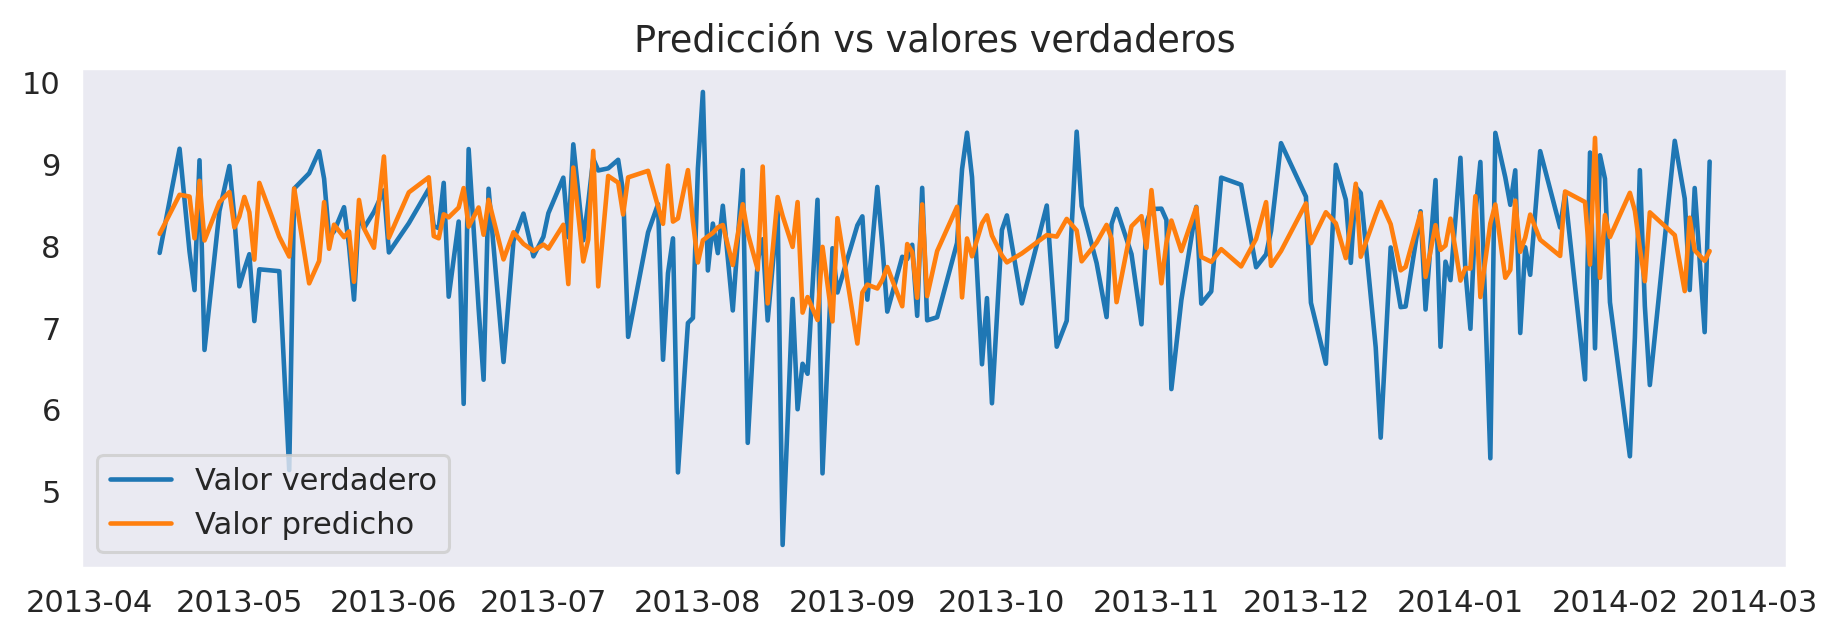

In [ ]:
# Visualización de los valores reales contra los valores predichos

plot_prediccion_real(y_pred_log, y_test_log, dtest_log)

In [ ]:
print(f"Test Mean Squared Error: \t{mean_squared_error(y_test_log, y_pred_log):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test_log, y_pred_log):.4f}")
print(f'Coeficiente de Determinación con r2_score:, {r2_score(y_test_log, y_pred_log):.4f}')

Test Mean Squared Error: 	1.2099
Test Mean Absolute Error: 	0.8189
Coeficiente de Determinación con r2_score:, -0.2583


Comparando el error cuadrático medio y el error absoluto medio del análisis con la serie de tiempo con datos originales y el análisis con la serie de tiempo con los datos en escala logarítmica se puede evideciar que el modelo con la serie de tiempo con datos en escala logarítmico está más alejado de los valores reaales (escalados logarítmicamente). 

Para tener una guía visual que facilite la comprensión de los datos y los resultados, se realizarán histogramas de la serie de datos real, la serie de datos ajustada (escala original) y la serie de datos escalados logaritmicamente.

Text(0.5, 1.0, 'Histograma valores reales')

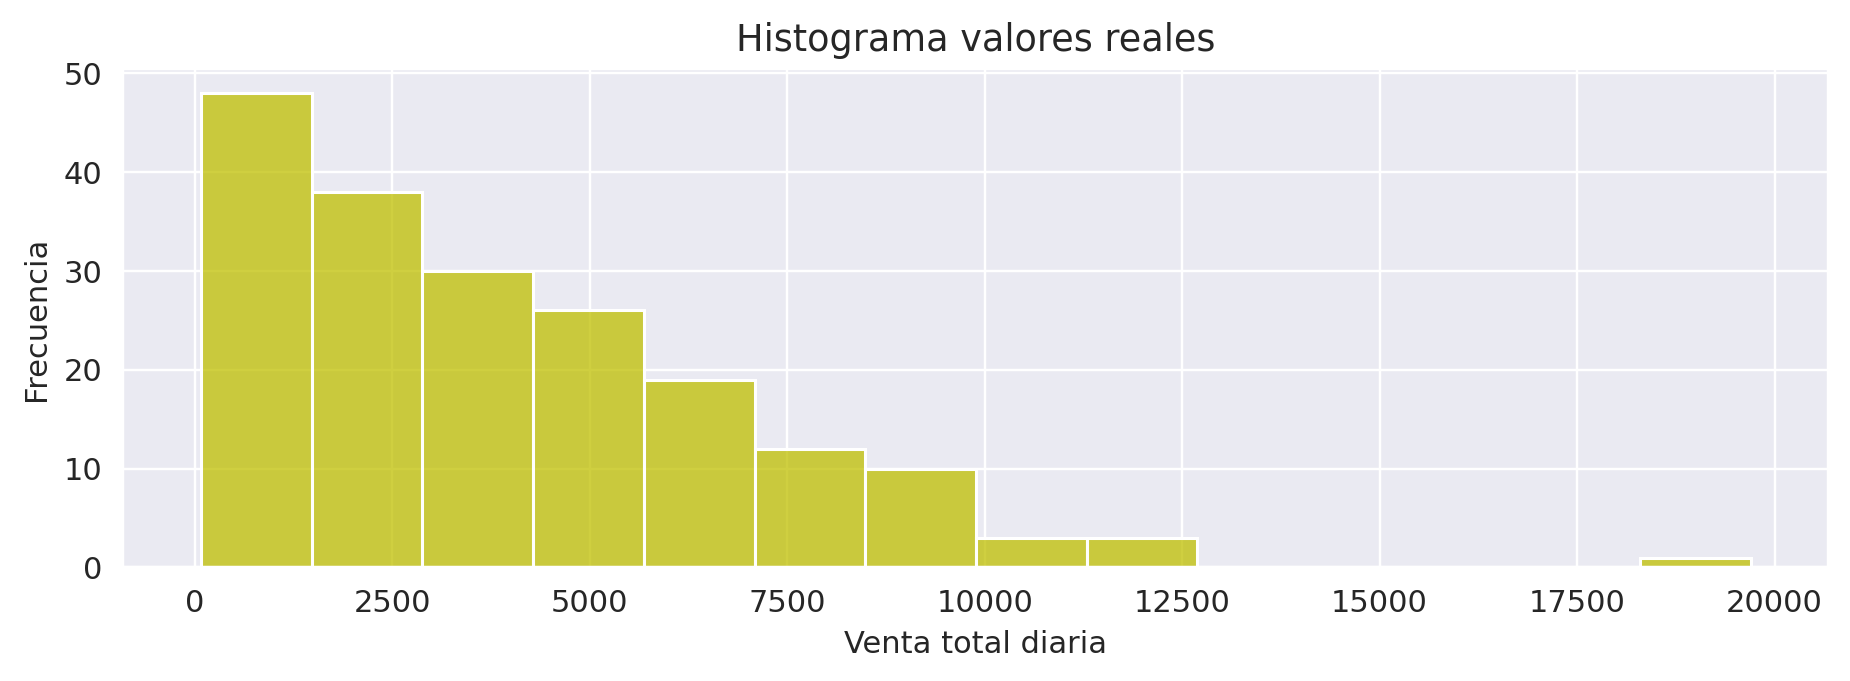

In [ ]:
# Histograma de datos reales

plt.figure(figsize=(10,3), dpi = 110)
sns.histplot(y_test, color='y')
plt.xlabel("Venta total diaria")
plt.ylabel("Frecuencia")
plt.title('Histograma valores reales')

Text(0.5, 1.0, 'Histograma valores predichos')

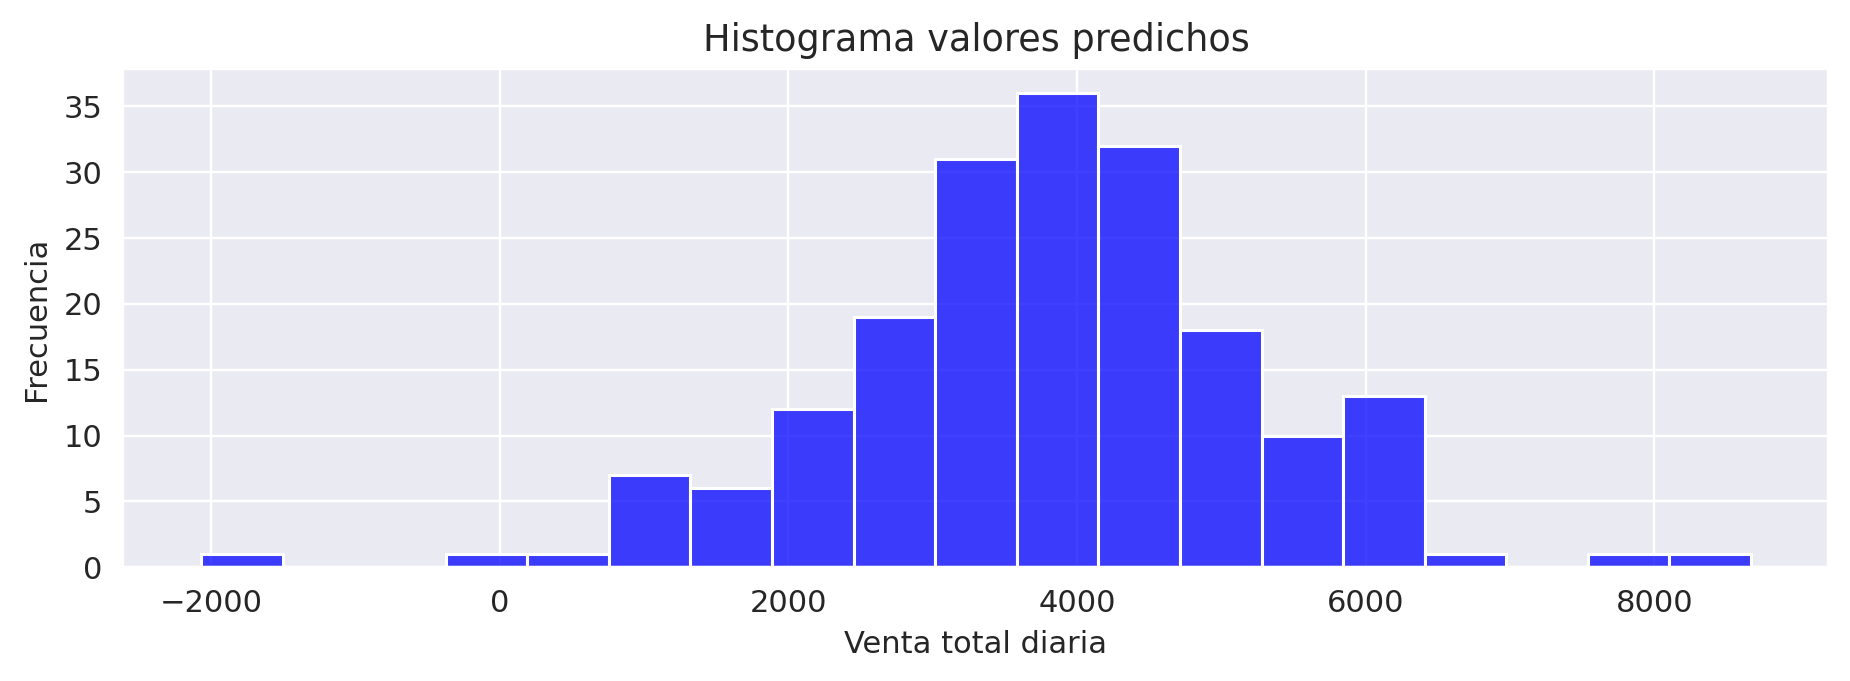

In [ ]:
# Histograma de datos predichos (escala original)

plt.figure(figsize=(10,3), dpi = 110)
sns.histplot(y_pred, color='b')
plt.xlabel("Venta total diaria")
plt.ylabel("Frecuencia")
plt.title('Histograma valores predichos')

In [ ]:
Estadisticas = pd.DataFrame(pd.Series(y_test)).describe()

In [ ]:
Estadisticas['y_pred'] = pd.Series(y_pred).describe()
Estadisticas

,0,y_pred
count,190.000000,190.000000
mean,3926.402316,3800.558312
std,3071.321851,1447.936785
min,77.350000,-2068.079488
25%,1447.273750,3023.263003
50%,3229.915000,3795.593874
75%,5707.601250,4653.934537
max,19702.150000,8669.379777


####**3.3. Serie de tiempo con datos reducidos (eliminación de datos extremos)**
---
Otro enfoque que puede tomarse es la evaluación de la serie de tiempo eliminando los valores extremos, que son pocos y sí modifican (posiblemente) el ajuste del modelo a la serie de tiempo. A partir de lo anterior y viendo que en la serie de prueba original el 75% de los datos están en un valor de 5686.05 podría realizarse nuevamente un análisis excluyendo datos que superen ventas diarias de 7000 (por dar un ejemplo).

In [ ]:
# Serie de datos originales reducidos (Xi <= 7000)

Teleshop_7000 = Books_Teleshop[Books_Teleshop <= 7000].dropna()
Teleshop_7000

,total_amt
Date,
2011-01-27,6310.655
2011-01-28,3038.750
2011-01-29,6663.150
2011-01-30,4685.200
2011-01-31,3244.280
...,...
2014-02-08,546.975
2014-02-15,5348.200
2014-02-16,1748.110


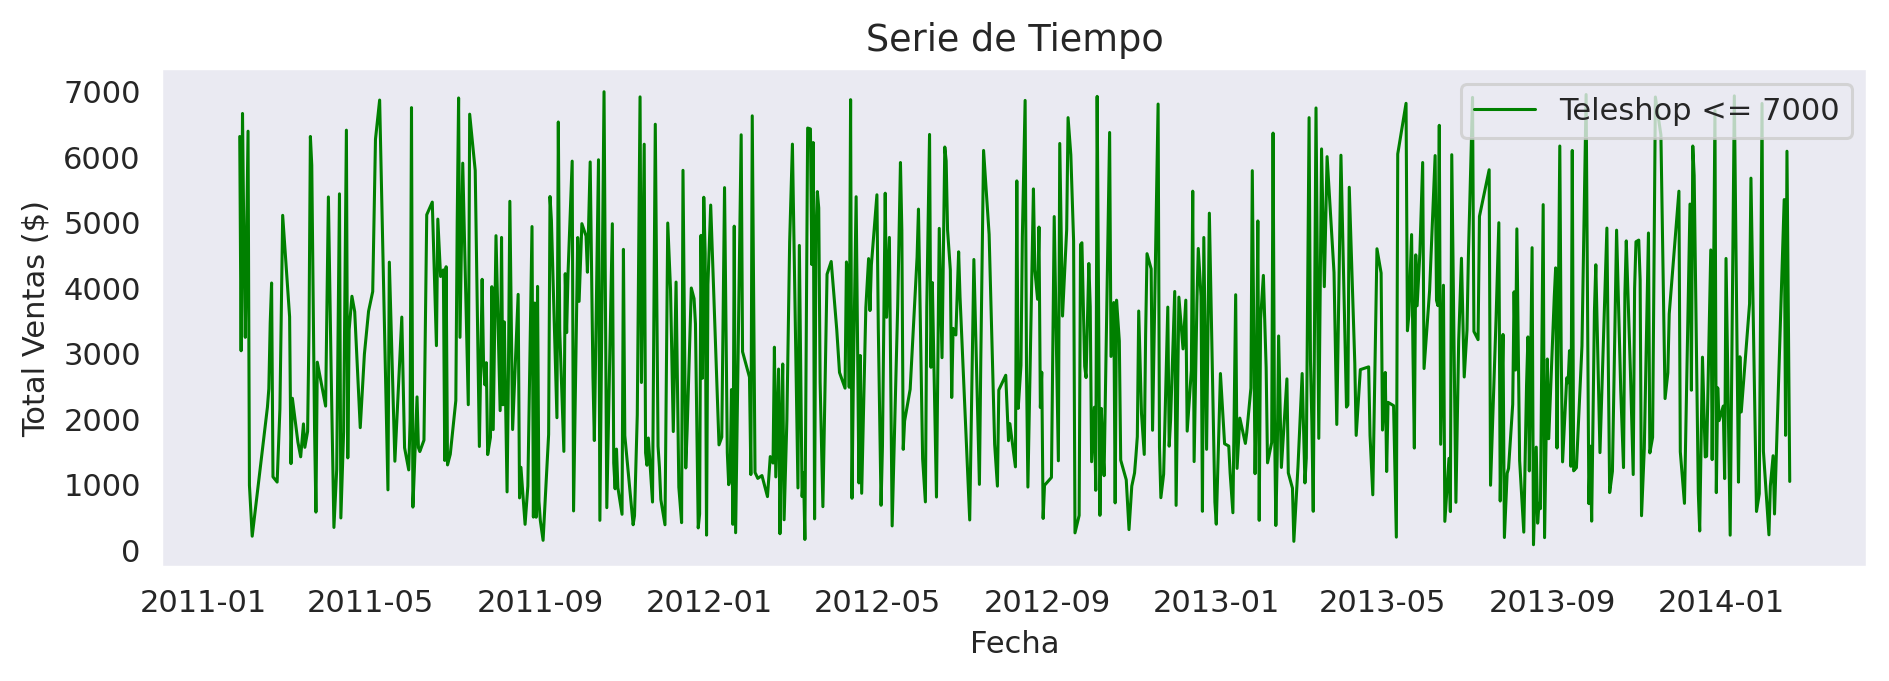

In [ ]:
# Gráfica de la serie de tiempo para las ventas diarias de libros (Books) a través del canal Teleshop <= 7000

print_series(Teleshop_7000, "Teleshop <= 7000")

In [ ]:
# Creación de las matrices X, series de tiempo y vectores y (datos menores a 7000)

X_train_7000, X_test_7000, y_train_7000, y_test_7000, dtrain_7000, dtest_7000 = Split_Window(Teleshop_7000, k, p)

In [ ]:
print('X_train_7000.shape:', X_train_7000.shape)
print('y_train_7000.shape', y_train_7000.shape)
print('X_test_7000.shape', X_test_7000.shape)
print('y_test_7000.shape', y_test_7000.shape)
print('dtrain_7000.shape', dtrain_7000.shape)
print('dtest_7000.shape', dtest_7000.shape)

X_train_7000.shape: (394, 20)
y_train_7000.shape (394,)
X_test_7000.shape (158, 20)
y_test_7000.shape (158,)
dtrain_7000.shape (414, 1)
dtest_7000.shape (178, 1)


In [ ]:
pd.DataFrame(X_train_7000).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,6310.655,3038.750,6663.150,4685.200,3244.280,6392.425,985.66,207.740,2179.060,2459.730,3460.860,4074.135,1113.840,1034.280,2149.225,5107.310,3558.100,1316.055,2313.870,1643.135
1,3038.750,6663.150,4685.200,3244.280,6392.425,985.660,207.74,2179.060,2459.730,3460.860,4074.135,1113.840,1034.280,2149.225,5107.310,3558.100,1316.055,2313.870,1643.135,1419.925
2,6663.150,4685.200,3244.280,6392.425,985.660,207.740,2179.06,2459.730,3460.860,4074.135,1113.840,1034.280,2149.225,5107.310,3558.100,1316.055,2313.870,1643.135,1419.925,1922.700
3,4685.200,3244.280,6392.425,985.660,207.740,2179.060,2459.73,3460.860,4074.135,1113.840,1034.280,2149.225,5107.310,3558.100,1316.055,2313.870,1643.135,1419.925,1922.700,1564.680
4,3244.280,6392.425,985.660,207.740,2179.060,2459.730,3460.86,4074.135,1113.840,1034.280,2149.225,5107.310,3558.100,1316.055,2313.870,1643.135,1419.925,1922.700,1564.680,1807.780


In [ ]:
pd.Series(y_train_7000)

0      1419.925
1      1922.700
2      1564.680
3      1807.780
4      3345.940
         ...   
389     129.285
390    1276.275
391    2691.780
392    1021.020
393    1401.140
Length: 394, dtype: float64

In [ ]:
# Creación del objeto TimeSeriesSplit para el análisis de la serie (Xi <= 7000)

tsp_7000 = TimeSeriesSplit(n_splits=3)

In [ ]:
# Se creará un nuevo objeto GridSearch, se utilizarán los mismos parámetros para la validación cruzada

gs_7000 = GridSearchCV(MLPRegressor(random_state=10),
                          cv=tsp,
                          param_grid=parametros)

In [ ]:
# Ajuste de la matriz X de entrenamiento y el vector de de entrenamiento al objeto GridSearch 7000

gs_7000.fit(X_train_7000, y_train_7000)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=200, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=10, shuffle=True,
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='depre

In [ ]:
clf_7000 = gridsearch.best_estimator_
clf_7000

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=10, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [ ]:
# Predicción de valores a través del modelo Xi <= 7000

y_pred_7000 = clf_7000.predict(X_test_7000)

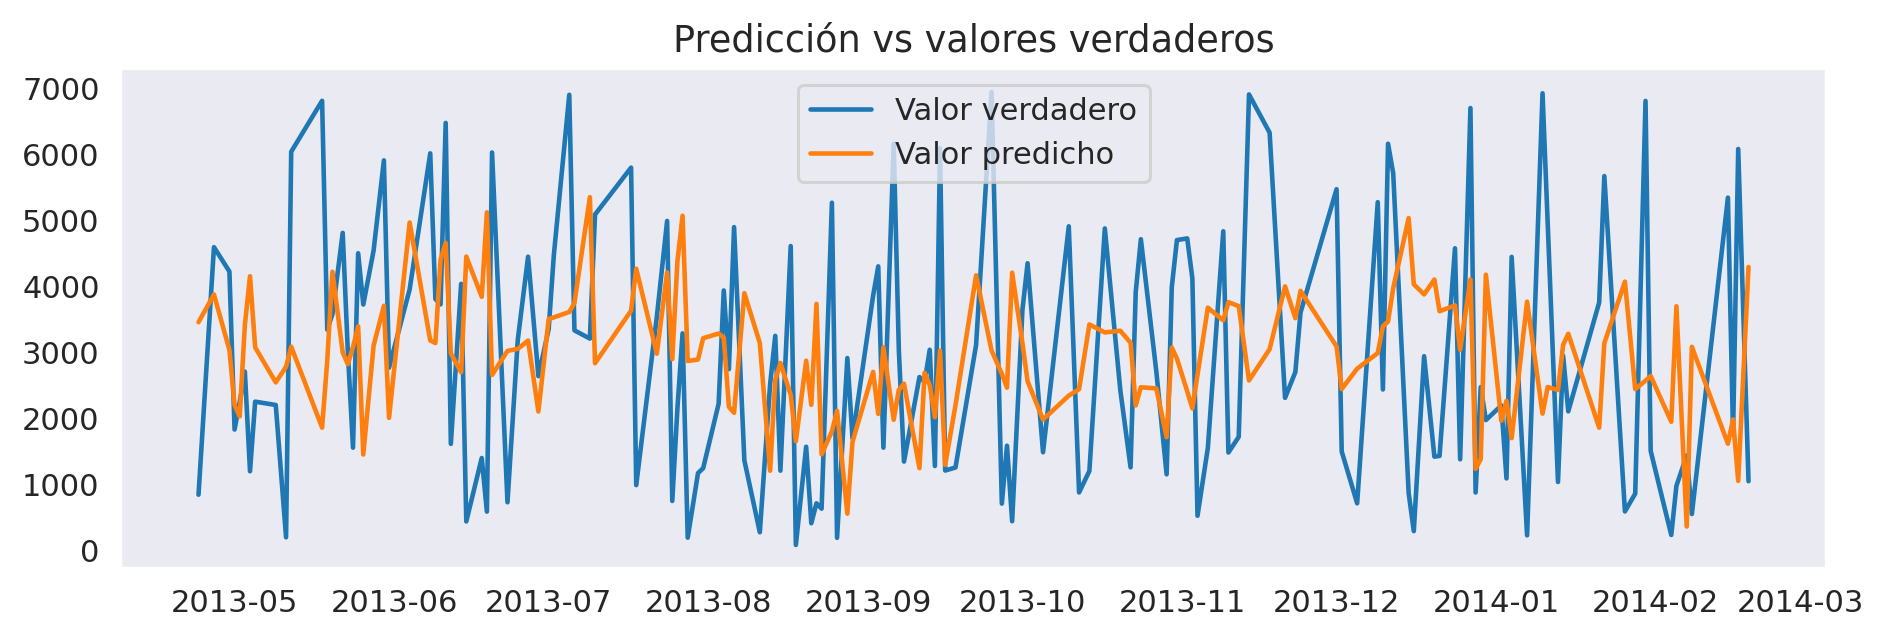

In [ ]:
# Visualización de los valores reales contra los valores predichos

plot_prediccion_real(y_pred_7000, y_test_7000, dtest_7000)

In [ ]:
# Métricas de desempeño

print(f"Test Mean Squared Error: \t{mean_squared_error(y_test_7000, y_pred_7000):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test_7000, y_pred_7000):.4f}")
print(f'Coeficiente de Determinación con r2_score:, {r2_score(y_test_7000, y_pred_7000):.4f}')

Test Mean Squared Error: 	4599161.6874
Test Mean Absolute Error: 	1811.7505
Coeficiente de Determinación con r2_score:, -0.2399


In [ ]:
print('Valor máximo predicho:',y_pred_7000.max())
print('Valor mínimo predicho:',y_pred_7000.min())

Valor máximo predicho: 5354.929684126109
Valor mínimo predicho: 357.0390062208439


##**4. Segmentación de Mercado: Clasificación por género** 
---
Dentro de la segmentación de mercados existe una subcategoría de segmentación que se centra en dividir los clientes a partir de su respectivo género (masculino y femenimo) llamado **marketing de género**. A partir de la información base que se tiene para el desarrollo de proyecto se implementará un árbol de decisión para hacer la segmentación y posteriormente se implementará un modelo de bosque aleatorio para verificar si es posible mejorar el desempeño del modelo inicial (árbol de decisiones) en dado caso que esto sea posible, 

####**4.1. Árbol de decisiones: Clasificación por género**
---
Inicialmente para la clasificación de clientes por su género se empleará un árbol de decisión. La información base ya para este punto está filtrada y preparada, lo que permite trabajar directamente en la elaboración del modelo. Adicionalmente, se eliminarán las categorías continuas y únicamnte se trabajará con variables categóricas:

In [ ]:
# Dataset con la información base

Transacciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23036 entries, 23035 to 0
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    23036 non-null  int64         
 1   cust_id           23036 non-null  int64         
 2   tran_date         23036 non-null  object        
 3   prod_subcat_code  23036 non-null  int64         
 4   prod_cat_code     23036 non-null  int64         
 5   Qty               23036 non-null  int64         
 6   Rate              23036 non-null  int64         
 7   Tax               23036 non-null  float64       
 8   total_amt         23036 non-null  float64       
 9   Store_type        23036 non-null  object        
 10  Age               23036 non-null  int64         
 11  Gender            23036 non-null  object        
 12  city_code         23036 non-null  float64       
 13  prod_cat          23036 non-null  object        
 14  prod_subcat       2303

In [ ]:
# Importar el árbol de decisión 

from sklearn.tree import DecisionTreeClassifier

Arbol_Clasificador = DecisionTreeClassifier()

Para poder realizar la elaboración del árbol de decisión se utilizará una codificación para las variables categóricas con OneHotEndonder.

In [ ]:
# Importar OneHotEncoder y StandarScaler

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
# Creación de dataframe de ejemplos con variables categóricas

columnas_X = ['prod_cat', 'Qty', 'Store_type', 'city_code']

dataframe_X = pd.DataFrame(Transacciones, columns=columnas_X)

dataframe_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23036 entries, 23035 to 0
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prod_cat    23036 non-null  object 
 1   Qty         23036 non-null  int64  
 2   Store_type  23036 non-null  object 
 3   city_code   23036 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 899.8+ KB


In [ ]:
# Creción que objeto que permita aplicar la codificación a los datos

preprocesamiento = ColumnTransformer([('onehot', OneHotEncoder(), columnas_X)])

In [ ]:
# Codificación de la información para el análisis

X_arbol = preprocesamiento.fit_transform(dataframe_X)
X_arbol.shape

(23036, 30)

In [ ]:
# Visualización de los nombres finales de la matriz codificada

onehot_categories = preprocesamiento.named_transformers_['onehot'].get_feature_names()

onehot_categories

array(['x0_Bags', 'x0_Books', 'x0_Clothing', 'x0_Electronics',
       'x0_Footwear', 'x0_Home and kitchen', 'x1_-5', 'x1_-4', 'x1_-3',
       'x1_-2', 'x1_-1', 'x1_1', 'x1_2', 'x1_3', 'x1_4', 'x1_5',
       'x2_Flagship store', 'x2_MBR', 'x2_TeleShop', 'x2_e-Shop',
       'x3_1.0', 'x3_2.0', 'x3_3.0', 'x3_4.0', 'x3_5.0', 'x3_6.0',
       'x3_7.0', 'x3_8.0', 'x3_9.0', 'x3_10.0'], dtype=object)

In [ ]:
# Cantidad de categorías posterior al proceso de codificación

onehot_categories.shape

(30,)

In [ ]:
# Creación del vector de etiquetas, no se hará codificación para este vector

y_arbol = Transacciones['Gender'].values
y_arbol.shape

(23036,)

In [ ]:
# Importar paquete para partición de datis

from sklearn import model_selection

In [ ]:
# Función auxiliar que permite crear la partición de entrenamiento y prueba

def particion(X, y, p=0.30):
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                      test_size=p,
                                                                      random_state=10,
                                                                      stratify=y
                                                                      )
  return X_train, y_train, X_test, y_test

In [ ]:
# División de los datos en X_train, y_train, X_test, y_test

X_train_arbol, y_train_arbol, X_test_arbol, y_test_arbol = particion(X_arbol, y_arbol, 0.3)

In [ ]:
# Tamaños de las particiones de entrenamiento y prueba de la matrices X y los vectores y

print('X_train_arbol.shape:', X_train_arbol.shape)
print('y_train_arbol.shape', y_train_arbol.shape)
print('X_test_arbol.shape', X_test_arbol.shape)
print('y_test_arbol.shape', y_test_arbol.shape)

X_train_arbol.shape: (16125, 30)
y_train_arbol.shape (16125,)
X_test_arbol.shape (6911, 30)
y_test_arbol.shape (6911,)


In [ ]:
# Creación del objeto árbol de decisión y entrenamiento con matriz X de objetos

Gender_Classifier = DecisionTreeClassifier()
Gender_Classifier = Gender_Classifier.fit(X_train_arbol, y_train_arbol)

In [ ]:
# Creación del vector de predicción con la matriz de entrenmiento 

y_pred_train = Gender_Classifier.predict(X_train_arbol)

In [ ]:
# Creación del vector de predicción con la matriz de prueba

y_pred_test = Gender_Classifier.predict(X_test_arbol)

In [ ]:
# Importar objetos para medir el acierto del modelo

from sklearn.metrics import accuracy_score

In [ ]:
# Precisión del modelo en los datos de entrenamiento

print(f'Puntaje de acierto en entrenamiento:',round(accuracy_score(y_train_arbol, y_pred_train), 3))
print(f'Puntaje de acierto en prueba:',round(accuracy_score(y_test_arbol, y_pred_test), 3))

resumen_arbol_1 = [round(accuracy_score(y_train_arbol, y_pred_train), 3), \
              round(accuracy_score(y_test_arbol, y_pred_test), 3)]

Puntaje de acierto en entrenamiento: 0.631
Puntaje de acierto en prueba: 0.515


###**4.2. Árbol de decisiones: Variables importantes**
---

Al revisar los resultados de puntaje de ajuste en entrenamiento y puntaje de ajuste en prueba se puede ver que el modelo tiene un desempeño relativamente (considerando un valor superior a 0.70 como aceptable), sin embargo este desempeño en la fase de prueba cae a la mitad de aciertos, lo cual evidentemente no es muy útil. Debido a este inconveniente se plantea revisar la importancia de cada una de las categorías y utilizar para el proceso de clasificación las categorías cuya importancia sea superior o igual a 2%.

In [ ]:
# Importancia de las características

importancia = pd.Series(Gender_Classifier.feature_importances_)
importancia.sort_values(ascending=False).head()

19    0.059439
16    0.058720
17    0.052293
18    0.050280
1     0.048826
dtype: float64

Revisando la importancia de las características se puede ver que hay 18 características que cumple la condición (importancia >= 2%), así que se realizará nuevamente la elaboración del árbol de decisión únicamente con estas características para ver cómo cambia el desempeño del clasificador.

In [ ]:
# Selección de las características con importancia gual o superior a 2%

importancia_M2 = importancia[importancia >= 0.02]

In [ ]:
# Índices de las características deseadas

index_importancia = importancia_M2.index
index_importancia

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 24, 25, 26, 27, 28],
           dtype='int64')

In [ ]:
# Dimensión de la nueva matriz de características

X_arbol_M2 = X_arbol[:,index_importancia]
X_arbol_M2.shape

(23036, 25)

In [ ]:
# Creación de las matrices X de entrenamiento y prueba y los vectores de etiquetas de entrenamiento y prueba

X_train_M2, y_train_M2, X_test_M2, y_test_M2 = particion(X_arbol_M2, y_arbol, 0.3)

In [ ]:
# Verificación de dimensiones de las matrices y vectores

print('X_train_M2.shape:', X_train_M2.shape)
print('y_train_M2.shape', y_train_M2.shape)
print('X_test_M2.shape', X_test_M2.shape)
print('y_test_M2.shape', y_test_M2.shape)

X_train_M2.shape: (16125, 25)
y_train_M2.shape (16125,)
X_test_M2.shape (6911, 25)
y_test_M2.shape (6911,)


In [ ]:
# Creación del objeto árbol de decisión y entrenamiento con matriz X de objetos

Gender_Classifier_M2 = DecisionTreeClassifier()
Gender_Classifier_M2 = Gender_Classifier_M2.fit(X_train_M2, y_train_M2)

In [ ]:
# Creación de los vectores de predicción en entrenamiento y prueba

y_pred_train_M2 = Gender_Classifier_M2.predict(X_train_M2)
y_pred_test_M2 = Gender_Classifier_M2.predict(X_test_M2)

In [ ]:
# Precisión del modelo en los datos de entrenamiento

print(f'Puntaje de acierto en entrenamiento:',round(accuracy_score(y_train_M2, y_pred_train_M2), 3))
print(f'Puntaje de acierto en prueba:',round(accuracy_score(y_test_M2, y_pred_test_M2), 3))

resumen_arbol_2 = [round(accuracy_score(y_train_M2, y_pred_train_M2), 3), \
                   round(accuracy_score(y_test_M2, y_pred_test_M2), 3)]

Puntaje de acierto en entrenamiento: 0.606
Puntaje de acierto en prueba: 0.515


El resultado de esta operación no ha sido muy satisfactorio, ya que sigue teniendo la mitad de errores al momento de clasificiar un cliente. A continución se realizará un procedimiento similar pero variando el objeto codificador de etiquetas. 

###**4.3. Árbol de decisiones: Label Encoder**
---

Un enfoque diferente a utilizar será emplear un objeto Label Encoder para ver las diferencias en los resultados obtenidos con el objeto OneHotEncoder.

In [ ]:
# Importar Label Encoder

from sklearn.preprocessing import LabelEncoder

In [ ]:
# Vector de etiquetas antes de la codificación 

y_LE = Transacciones['Gender']

In [ ]:
y_LE.head()

23035    M
23016    F
23017    M
23018    M
23019    F
Name: Gender, dtype: object

In [ ]:
# Creación de dataframe de ejemplos con variables categóricas

columnas_LE = ['prod_cat', 'Qty', 'Store_type', 'city_code', 'Gender']

dataframe_LE = pd.DataFrame(Transacciones, columns=columnas_LE)

dataframe_LE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23036 entries, 23035 to 0
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prod_cat    23036 non-null  object 
 1   Qty         23036 non-null  int64  
 2   Store_type  23036 non-null  object 
 3   city_code   23036 non-null  float64
 4   Gender      23036 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.1+ MB


In [ ]:
# Aplicación de Label Encoder en el dataset

dataframe_LE = dataframe_LE.apply(LabelEncoder().fit_transform)
dataframe_LE

,prod_cat,Qty,Store_type,city_code,Gender
23035,1,5,2,0,1
23016,2,5,0,5,0
23017,3,5,1,3,1
23018,2,7,1,8,1
23019,1,9,2,0,0
...,...,...,...,...,...
4,1,3,2,7,1
3,5,2,3,2,1
2,1,3,2,7,1
1,3,0,3,7,0


In [ ]:
# Transformación del DataFrame X a un arreglo de numpy

X_LE = dataframe_LE.drop(['Gender'], axis=1).values # Eliminar la 

X_LE

array([[1, 5, 2, 0],
       [2, 5, 0, 5],
       [3, 5, 1, 3],
       ...,
       [1, 3, 2, 7],
       [3, 0, 3, 7],
       [2, 0, 3, 4]])

In [ ]:
# Transformación de 

y_LE = dataframe_LE['Gender'].values
y_LE

array([1, 0, 1, ..., 1, 0, 1])

**En la codificación anterior se puede ver que en el Género del cliente (Gender) 1 es Masculino y 0 es Femenino.**

In [ ]:
# Creación de las matrices X de entrenamiento y prueba y los vectores de etiquetas de entrenamiento y prueba

X_train_LE, y_train_LE, X_test_LE, y_test_LE = particion(X_LE, y_LE, 0.3)

In [ ]:
# Verificación de dimensiones de las matrices y vectores

print('X_train_LE.shape:', X_train_LE.shape)
print('y_train_LE.shape', y_train_LE.shape)
print('X_test_LE.shape', X_test_LE.shape)
print('y_test_LE.shape', y_test_LE.shape)

X_train_LE.shape: (16125, 4)
y_train_LE.shape (16125,)
X_test_LE.shape (6911, 4)
y_test_LE.shape (6911,)


In [ ]:
# Creación del objeto árbol de decisión y entrenamiento con matriz X de objetos

Gender_Classifier_LE= DecisionTreeClassifier()
Gender_Classifier_LE = Gender_Classifier_LE.fit(X_train_LE, y_train_LE)

In [ ]:
# Creación de los vectores de predicción en entrenamiento y prueba

y_pred_train_LE = Gender_Classifier_LE.predict(X_train_LE)
y_pred_test_LE = Gender_Classifier_LE.predict(X_test_LE)

In [ ]:
# Precisión del modelo en los datos de entrenamiento

print(f'Puntaje de acierto en entrenamiento:',round(accuracy_score(y_train_LE, y_pred_train_LE), 3))
print(f'Puntaje de acierto en prueba:',round(accuracy_score(y_test_LE, y_pred_test_LE), 3))

resumen_arbol_3 = [round(accuracy_score(y_train_LE, y_pred_train_LE), 3), \
                   round(accuracy_score(y_test_LE, y_pred_test_LE), 3)]

Puntaje de acierto en entrenamiento: 0.631
Puntaje de acierto en prueba: 0.513


###**4.4. Bosques Aleatorios: Clasificación por género**
---
Buscando un mejor clasificador de género para los clientes, se decide aplicar un modelo de bosques aleatorios para evaluar y comparar el desempeño de este último con el desempeño obtenido con un único modelo de árbol de decisión.

In [ ]:
# Importar paquete de bosques aleatorios

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Matriz de ejemplos X

X_RF = pd.DataFrame(Transacciones, columns=['prod_cat', 'Qty', 'Store_type', 'city_code'])
X_RF.head()

,prod_cat,Qty,Store_type,city_code
23035,Books,1,TeleShop,1.0
23016,Clothing,1,Flagship store,6.0
23017,Electronics,1,MBR,4.0
23018,Clothing,3,MBR,9.0
23019,Books,5,TeleShop,1.0


In [ ]:
# Vector de etiquetas y

y_RF = Transacciones['Gender']
y_RF.head()

23035    M
23016    F
23017    M
23018    M
23019    F
Name: Gender, dtype: object

In [ ]:
# Separación de datos en entrenamiento y prueba

X_train_RF, y_train_RF, X_test_RF, y_test_RF = particion(X_RF, y_RF, 0.3)

In [ ]:
print('X_train_RF.shape:', X_train_RF.shape)
print('y_train_RF.shape', y_train_RF.shape)
print('X_test_RF.shape', X_test_RF.shape)
print('y_test_RF.shape', y_test_RF.shape)

X_train_RF.shape: (16125, 4)
y_train_RF.shape (16125,)
X_test_RF.shape (6911, 4)
y_test_RF.shape (6911,)


In [ ]:
# Parámetros para el modelo de bosques aleatorios

param_RF = {
    'n_estimators' : [30,40,50,60,70,80,90,100],
    'max_depth' : [2,3,4],
    'min_samples_split' : [2,3,4],
    'min_samples_leaf' : [1,2]
}

In [ ]:
# Definición del modelo Random Forest

RF_Gender_clf = RandomForestClassifier()

In [ ]:
# Definición del objeto GridSearch para la evaluación de Random Forest

gs_RForest = GridSearchCV(RF_Gender_clf,
                          param_grid=param_RF,
                          cv=3)

In [ ]:
# Entrenamiento de Random Forest

gs_RForest.fit(X_train_arbol, y_train_arbol)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
# Visualización de los mejores estimadores

gs_RForest.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred_train_RF = gs_RForest.predict(X_train_arbol)

In [ ]:
y_pred_test_RF = gs_RForest.predict(X_test_arbol)

In [ ]:
# Precisión del modelo en los datos de entrenamiento

print(f'Puntaje de acierto en entrenamiento:',round(accuracy_score(y_train_arbol, y_pred_train_RF), 3))
print(f'Puntaje de acierto en prueba:',round(accuracy_score(y_test_arbol, y_pred_test_RF), 3))

resumen_rf = [round(accuracy_score(y_train_arbol, y_pred_train_RF), 3), \
              round(accuracy_score(y_test_arbol, y_pred_test_RF), 3)]

Puntaje de acierto en entrenamiento: 0.545
Puntaje de acierto en prueba: 0.522


In [ ]:
lista=[resumen_arbol_1, resumen_arbol_2,resumen_arbol_3,resumen_rf]

In [ ]:
# Cuadro resumen de los puntajes de acierto de los 4 análisis de clasificación

resumen = pd.DataFrame(lista, columns=['Train Error', 'Test Error'], index=['Árbol 1','Árbol 2','Árbol 3', 'Random Forest'])
resumen

,Train Error,Test Error
Árbol 1,0.631,0.515
Árbol 2,0.606,0.515
Árbol 3,0.631,0.513
Random Forest,0.545,0.522


Observando los resultados del árbol de decisión se decide emplear un modelo diferente para buscar mejores resultados de clasificación. 

###**4.5. Regresión Logística: Clasificación por género**
---
Cambiando el enfoque del clasificador de género se empeará un modelo de regresión logística para realizar esta actividad.

In [ ]:
# Importar paquete de regresión logística

from sklearn.linear_model import LogisticRegression

In [ ]:
# Creación y entrenamiento del modelo de regresión

lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs');
lr_model.fit(X_arbol, y_arbol)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Visualización del vector de predicción en entrenamiento

y_LR_train_pred = lr_model.predict(X_train_arbol)
y_LR_train_pred

array(['M', 'M', 'M', ..., 'M', 'M', 'F'], dtype=object)

In [ ]:
# Visualización del vector de predicción en prueba

y_LR_test_pred = lr_model.predict(X_test_arbol)
y_LR_test_pred

array(['M', 'M', 'M', ..., 'M', 'F', 'M'], dtype=object)

In [ ]:
# Precisión del modelo en los datos de entrenamiento

print(f'Puntaje de acierto en entrenamiento:',round(accuracy_score(y_train_arbol, y_LR_train_pred), 3))
print(f'Puntaje de acierto en prueba:',round(accuracy_score(y_test_arbol, y_LR_test_pred), 3))

resumen_rf = [round(accuracy_score(y_train_arbol, y_pred_train_RF), 3), \
              round(accuracy_score(y_test_arbol, y_pred_test_RF), 3)]

Puntaje de acierto en entrenamiento: 0.54
Puntaje de acierto en prueba: 0.527


Infortunadamente el resultado no fue mejor que el obtenido por árboles de decisión ni bosques aleatorios.

###**4.6. Vecinos más cercanos K: Clasificación por género**
---
Quizá un modelo de agrupamiento sea más efectivo al momento de relizar la clasificación de género de los clientes. En esta sección se evaluará el modelo de KNeighborsClassifier.

In [ ]:
# Importar el modulo del clasificaor KNC

from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Creación del modelo

knn = KNeighborsClassifier()

In [ ]:
# Celda que permite iterar a través del número de vecinos para realizar la gráfica de errores de entrenamiento y prueba

k_values = 20

train_error = []
generalization_error = []
n_conjuntos = []
contador = 0

for nn in range(1, k_values + 1):
    knn = KNeighborsClassifier(n_neighbors=nn)
    knn.fit(X_train_arbol, y_train_arbol)
    train_error.append(1 - knn.score(X_train_arbol, y_train_arbol))
    generalization_error.append(1 - knn.score(X_test_arbol, y_test_arbol))
    contador += 1
    n_conjuntos.append(contador)

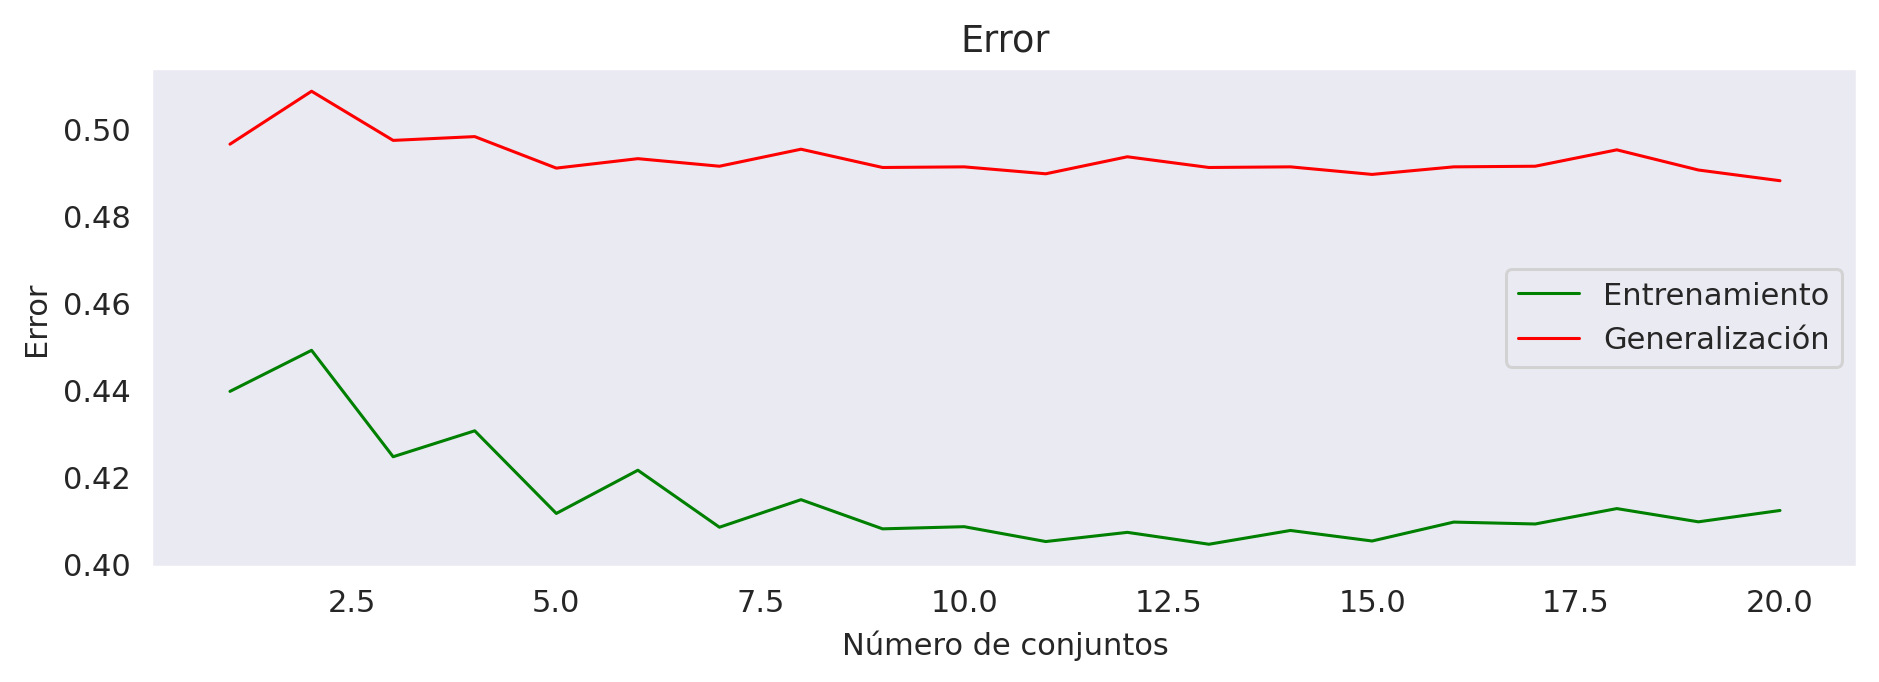

In [ ]:
plt.figure(figsize=(10,3), dpi = 110)
plt.plot(n_conjuntos, train_error, color="g", label='Entrenamiento', linewidth=1)
plt.plot(n_conjuntos, generalization_error, color="r", label='Generalización', linewidth=1)
plt.title('Error')
plt.grid()
plt.legend()
plt.xlabel("Número de conjuntos")
plt.ylabel("Error")
print()

Observando la gráfica se puede notar algo interesante, incluso cuando el número de vecinos K es 1 no se tienen un error de 0, eso significa que de todos los registro de clientes, existen muchos con hábitos de compra iguales (al menos con las categorías analizadas) pero de diferente género, lo que le impide a cualquier algoritmo encontrar un patrón de clasificación que no se base en aleatoriedad.

##**5. Conclusiones**
---
*   **Serie de tiempo:** En el primer modelo de series de tiempo (serie de tiempo original) el valor máximo en la predicción de la serie de tiempo es aproximadamente 8670, valor que dentro de lo regristrado históricamente no es anormal. Sin embargo el valor mínimo es de 2070, que dentro del contexto actual no tiene mucho sentido, podría interpretarse como una devolución de algún libro, sin embargo implicaría una devolución de una gran cantidad de libros en un mismo día, situación que es poco probable. En el segundo modelo (con datos ajustados logarítmicamente) las estadísticas de la serie de tiempo real y la serie de tiempo predicha se observa una tendencia al mismo valor en cuanto a lo que media aritmética refiere, sin embargo para las distribuciones de frecuencias muestran una tendencia a una distribución normal en la serie de tiempo predicha y en la serie de tiempo original se ve una tendencia a una log normal (entre otras). En el tercer modelo (Serie de tiempo eliminando datos extremos) los valores altos de ventas tienden a afectar el ajuste de la serie de tiempo predicha, y pueden ser producto de promociones o descuentos que, lamentablemente no están registradas dentro de la información base. Por lo que si se tuviera que tomar una decisión de un mejor ajuste, se elegiría el ajuste realizado con los datos sin valores extremos debido a su menor error y a los valores mínimos y máximos presentes en la predicción.

*   **Clasificación:** A partir del cuadro resumen presentado anteriormente se pueden sacar varias conclusiones, la primera es que a pesar de las variaciones en los modelos tratando de encontrar un mejor ajuste no se logró obtener un mayor porcentaje a 53% de acierto con los datos de prueba (valor obtenido a partir de un modelo de bosques aleatorios). La eliminación de variables que no tienen un porcentaje de importancia mayor a 2% no generó un mejor resultado y la codificación con OneHotEncoder y LabelEncoder no varían en cuanto a resultados, sin embargo el proceso de elaboración del modelo a través de la codificación OneHotEncoder conlleva más líneas de código y genera una matriz de observaciones más grande lo que incrementa la complejidad espacial. Si se tuviera que elegir un modelo para la clasificación de clients a través de su género, se optaría por el modelo del árbol 2, el cual utilizó LaberEncoder; puede que el modelo con Random Forest tenga un puntaje de aciertos ligeramente superior, el costo computacional es mucho mayor en este último, y el tiempo de ejecución (al menor para la elaboración de este proyecto) es superior a los 10 minutos, tiempo que no se justifica emplear para obtener menos de un 2% de mejor en el accuracy score. Finalmente, y a partir de este análisis podría intuirse que no hay una correlación entre las características utilizadas para la clasificación de los clientes y el género de los mismos.

##**6. Referencias**
---
Enlace donde se puede encontrar el conjuto de datos utilizado para el desarrollo de este notebook.


https://www.kaggle.com/darpan25bajaj/retail-case-study-data